#Installation

In [1]:
!pip install numpy==2.0.2 -q > /dev/null
!pip install pandas==2.2.2 -q > /dev/null
!pip install matplotlib==3.10.0 -q > /dev/null
!pip install bokeh==3.7.3 -q > /dev/null
!pip install pathos==0.3.4 -q > /dev/null
!pip install stumpy==1.13.0 -q > /dev/null
!pip install tsfresh==0.21.1 -q > /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.0.0 requires dill<0.3.9,>=0.3.0, but you have dill 0.4.0 which is incompatible.
datasets 4.0.0 requires multiprocess<0.70.17, but you have multiprocess 0.70.18 which is incompatible.


#TSFresh features generation

####configuration

In [2]:
import numpy as np
from typing import Dict, List, Optional, Any, Union


class TsFreshConfigurator:
    """
    Configurator for TsFresh time series feature extraction settings.

    This class generates configuration dictionaries that control which features
    TsFresh extracts and their parameters. It wraps the original mathematical
    logic while providing a clean, configurable API.

    Core Concepts:
        • ts_len: Time series length - length of time series for which features are generated
        • lags: Autocorrelation delays - key for time-dependent features
        • bins: Discretization buckets - for entropy and complexity features

    Feature Availability Tiers:
        • ts_len >= 1: Basic statistics (mean, std, min, max, median)
        • ts_len >= 4: Advanced statistics + FFT + autocorrelation
        • ts_len >= 6: Complex patterns (polynomial, permutation entropy)

    Attributes:
        LAG_COEF - Limits maximal lag to 50% of series length (ts_len) (0.1, 0.9]
        MAX_BINS - Maximum number of bins for discretization features
        AR_LAST_COEF - Controls AR coefficient range generation [-1, -10]
        MAX_FOURIER_COEFS - # Limits FFT coefficients to reduce computation
        LAG_PRESETS - Defines the set of lags for generating lags-depended features, p.s. the set will be limited by LAG_COEF * ts_len
        FEATURE_PRESETS - Defines a set of tsfresh features for generation
    """

    # Feature extraction constants
    LAG_COEF = 0.5
    MAX_BINS = 10
    AR_LAST_COEF = -5
    MAX_FOURIER_COEFS = 20

    # Lag presets for different analysis depths
    LAG_PRESETS = {
        "minimal": np.array([2, 3, 5, 10, 21, 50, 150, 300, 600]),
        "efficient": np.array([2, 3, 5, 7, 10, 15, 21, 35, 50, 70, 100, 150, 300, 450, 600]),
        "comprehensive": np.array([2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 17, 19, 21, 25, 28, 32,
                                   35, 40, 50, 70, 90, 100, 110, 130, 150, 170, 190, 210, 230,
                                   250, 280, 300, 350, 400, 450, 500, 550, 600])
    }

    # Feature presets for common use cases
    FEATURE_PRESETS = {
        "minimal": ["mean", "std", "minimum", "maximum", "median"],
        "efficient": [
            "mean", "std", "minimum", "maximum", "median", "quantile",
            "abs_energy", "mean_abs_change", "autocorrelation", "c3", "linear_trend"
        ],
        "statistical": [
            "mean", "std", "variance", "minimum", "maximum", "median",
            "kurtosis", "skewness", "quantile", "count_above_mean", "count_below_mean"
        ],
        "comprehensive": None  # Use all available features
    }

    def __init__(self, ts_len: int = 10, lags: Union[str, List[int], np.ndarray] = "efficient"):
        """
        Initialize configurator with smart lag selection.

        Args:
            ts_len: Length of time series for feature extraction.
                   Must be >= 1. Determines available features:
                   - ts_len >= 1: Basic statistical features (mean, std, min, max)
                   - ts_len >= 4: Advanced features (autocorrelation, FFT, kurtosis)
                   - ts_len >= 6: Complex features (permutation entropy, polynomial)

            lags: Lag configuration. Can be:
                  - str: Preset name ("minimal", "efficient", "comprehensive")
                  - list/array: Custom lag values [1, 5, 10, ...]
                  All lags > LAG_COEF * ts_len are automatically deleted.
        """
        if ts_len < 1:
            raise ValueError(f"ts_len must be >= 1, got {ts_len}")

        self.ts_len = ts_len
        if isinstance(lags, str):
            # Use named preset
            if lags not in self.LAG_PRESETS:
                raise ValueError(f"Unknown lag preset: {lags}. Available: {list(self.LAG_PRESETS.keys())}")
            provided_lags = self.LAG_PRESETS[lags]
        elif lags is None:
            raise ValueError("lags should be str or list or np.ndarray not None.")
        else:
            # Use custom lag values
            provided_lags = np.array(lags)

        # Filter lags based on LAG_COEF constraint (50% of ts_len)
        max_lag = ts_len * self.LAG_COEF
        valid_lags = provided_lags[provided_lags < max_lag]

        # Always ensure lag=1 is included
        if len(valid_lags) == 0 or 1 not in valid_lags:
            valid_lags = np.append([1], valid_lags)

        self.lags = np.unique(valid_lags)  # Remove duplicates and sort

        # Configuration options
        self._preset = None
        self._include_features = None
        self._exclude_features = []
        self._custom_params = {}

        # Core calculations
        # Bins: from 2 up to min(10, half of ts_len) for discretization
        self.bins = list(range(2, min(self.MAX_BINS, ts_len//2 + 1)))
        # Chunk lengths for splitting series into segments
        self.chunk_lens = [ts_len//p for p in self.bins] if self.bins else []

        # Stats
        self.features_count = None # Counted after settings generation

    def _get_lags_settings(self) -> List[Dict[str, int]]:
        """Generate settings for lag-based features (autocorrelation, c3, etc.)"""
        return [{"lag": int(l)} for l in self.lags]


    def _get_bins_settings(self) -> List[Dict[str, int]]:
        """Generate settings for binning/discretization features"""
        return [{"bins": b} for b in self.bins]


    def _get_quintile_settings(self) -> List[Dict[str, float]]:
        """Generate quantile settings with adaptive step size based on series length"""
        # Step size: max(0.1, 1/ts_len) ensures at least 10% steps for short series
        return [{"q": float(q)} for q in np.arange(0.01, 1, max(0.1, 1/self.ts_len)).round(2)]


    def _get_aggregated_settings(
        self,
        task: str,
        chunk_lens: Union[List, np.ndarray],
        agg_functions: List[str] = ["mean", "std", "var", "median", "min", "max"]
        ) -> List[Dict[str, Any]]:
        """Generate settings for aggregated features (complex multi-parameter features)"""
        aggregated_settings = []
        for a_f in agg_functions:
            if task == "lags":
                for l in self.lags:
                    # Skip variance/std for lag=1 (mathematically undefined for single lag)
                    if l == 1 and (a_f == "var" or a_f == "std"):
                        continue
                    aggregated_settings.append({"f_agg": a_f, "maxlag": l})
            elif task == "linear":
                if a_f == "median":
                    continue
                for a_r in ["pvalue", "rvalue", "intercept", "slope", "stderr"]:
                    for c_l in chunk_lens:
                        aggregated_settings.append({"attr": a_r, "chunk_len": c_l, "f_agg": a_f})
            elif task == "quantiles":
                for ql in np.arange(0.01, 1, max(0.1, 1/self.ts_len)).round(2):
                    for qh in np.arange(0.01, 1, max(0.1, 1/self.ts_len)).round(2):
                        if ql >= qh:
                            continue
                        aggregated_settings.append({"f_agg": a_f,  "isabs": False, "qh": qh, "ql": ql})
        return aggregated_settings

    def _get_ar_settings(self) -> List[Dict[str, int]]:
        """Generate autoregressive (AR) coefficient settings"""
        ar_settings = []
        for l in self.lags:
            # Skip lags >= half of series length (insufficient data for AR model)
            if l >= self.ts_len//2:
                continue
            for ar_c in range(-1, self.AR_LAST_COEF - 1, -1):
                # Skip if lag is less than coefficient index (invalid AR configuration)
                if l < abs(ar_c):
                    continue
                ar_settings.append({"coeff": ar_c, "k": l})
        return ar_settings

    def _get_dickey_fuller_settings(
        self,
        attr: List[str] = ["teststat", "pvalue", "usedlag"],
        autolag: List[Optional[str]] = ["AIC", None]
        ) -> List[Dict[str, Any]]:
        """Generate settings for Augmented Dickey-Fuller test (stationarity test)"""
        dickey_fuller_settings = []
        for a in attr:
            for l in autolag:  # AIC for automatic lag selection, None for fixed lag
                dickey_fuller_settings.append({"attr": a, "autolag": l})
        return dickey_fuller_settings


    def _get_erbc_settings(self) -> List[Dict[str, int]]:
        """Generate settings for energy ratio by chunks feature"""
        erbc_settings = []
        for b in self.bins:
            for i in range(b):  # Each segment focus for the given number of segments
                erbc_settings.append({"num_segments": b, "segment_focus": i})
        return erbc_settings


    def _get_fft_coefs_settings(self) -> List[Dict[str, Any]]:
        """Generate FFT coefficient settings"""
        fft_coefs_settings = []
        # Limit to ts_len//2 (Nyquist frequency) and max_fourier_coefs
        for i in range(1, min(self.MAX_FOURIER_COEFS, self.ts_len//2)):
            for a in ["real", "angle"]:  # Both real and angle components
                fft_coefs_settings.append({"attr": a, "coeff": i})
        return fft_coefs_settings


    def _get_polynomial_settings(self, method: str = "friedrich") -> List[Dict[str, int]]:
        """Generate settings for Friedrich/Langevin polynomial coefficients"""
        coefs_settings = []
        for d in range(1, 6):  # Polynomial degree 1-5
            # Window size: min 2, max 20, step 2, limited by ts_len//3
            for q in range(2, min(21, self.ts_len//3 + 1), 2):
                if method == "langevin":
                    coefs_settings.append({"m": d, "r": q})
                    continue
                # Friedrich: generate for each coefficient of the polynomial
                for c in range(1, d+1):
                    coefs_settings.append({"coeff": c, "m": d, "r": q})
        return coefs_settings


    def _get_permutation_settings(self) -> List[Dict[str, int]]:
        """Generate settings for permutation entropy (complexity measure)"""
        permutation_settings = []
        # Adaptive step size: max(1, 5% of series length) prevents too many calculations
        for d in range(2, self.ts_len//2, max(1, int(self.ts_len * 0.05))):
            for t in range(1, min(5, self.ts_len - d)):  # Time delay tau: 1-4
                # Skip if not enough data points for meaningful permutation patterns
                if self.ts_len//t < 4:
                    continue
                permutation_settings.append({"dimension": d, "tau": t})
        return permutation_settings

    @staticmethod
    def _count_tsfresh_features(settings: Dict[str, Any]) -> int:
        """
        Count total number of features from TsFresh settings dictionary.

        TsFresh settings structure:
        - None value = 1 simple feature without parameters (e.g., 'mean': None)
        - List value = N parameterized features (e.g., 'quantile': [{'q': 0.1}, {'q': 0.2}] = 2 features)

        Args:
            settings: TsFresh settings dictionary from TsFreshConfigurator.build()

        Returns:
            Total count of features that will be extracted
        """
        features_count = 0
        for k, v in settings.items():
            if v is not None:
                features_count += len(v)
            else:
                features_count += 1
        return features_count

    def preset(self, preset_name: str) -> "TsFreshConfigurator":
        """Use a feature preset configuration."""
        if preset_name not in self.FEATURE_PRESETS:
            raise ValueError(f"Unknown feature preset: {preset_name}")
        self._preset = preset_name
        return self

    def include_features(self, features: List[str]) -> "TsFreshConfigurator":
        """Include only specified features."""
        self._include_features = features
        return self

    def exclude_features(self, features: List[str]) -> "TsFreshConfigurator":
        """Exclude specified features."""
        self._exclude_features.extend(features)
        return self

    def with_custom_params(self, feature: str, params: Any) -> "TsFreshConfigurator":
        """Set custom parameters for a specific feature. """
        self._custom_params[feature] = params
        return self

    def get_info(self) -> Dict[str, Any]:
        """Get information about current configuration."""
        return {
            "ts_len": self.ts_len,
            "lags": self.lags.tolist(),
            "bins_available": len(self.bins) > 0,
            "bins": self.bins,
            "features_available": {
                "basic": True,  # Always available
                "advanced": self.ts_len >= 4,
                "complex": self.ts_len >= 6,
                "binning": len(self.bins) > 0
            },
            "features_count": self.features_count,
        }

    def build(self) -> Dict[str, Any]:
        """Build the settings dictionary."""
        # Generate all possible settings
        all_settings = self._generate_all_settings()

        # Apply filtering based on configuration
        if self._include_features:
            # Include only specified features
            settings = {
                k: v for k, v in all_settings.items()
                if k in self._include_features
            }
        elif self._preset and self.FEATURE_PRESETS[self._preset]:
            # Use preset features
            preset_features = self.FEATURE_PRESETS[self._preset]
            settings = {
                k: v for k, v in all_settings.items()
                if k in preset_features
            }
        else:
            # Use all features
            settings = all_settings

        # Apply exclusions
        for feature in self._exclude_features:
            settings.pop(feature, None)

        # Apply custom parameters
        for feature, params in self._custom_params.items():
            settings[feature] = params

        # Write the number of features that will be generated from the settings
        self.features_count = self._count_tsfresh_features(settings)

        return settings

    def _generate_all_settings(self) -> Dict[str, Any]:
        """Generate all possible settings."""
        settings = {
            "abs_energy": None,
            "absolute_maximum": None,
            "absolute_sum_of_changes": None,
            "agg_autocorrelation": self._get_aggregated_settings(
                task="lags",
                chunk_lens=self.chunk_lens
                ),
            "agg_linear_trend": self._get_aggregated_settings(
                task="linear",
                # Skip first chunk (self.[1:]) as it's the entire series (not meaningful)
                chunk_lens=self.chunk_lens[1:] if len(self.chunk_lens) > 1 else []
            ),
            "c3": self._get_lags_settings(),
            "change_quantiles": self._get_aggregated_settings(
                task="quantiles",
                chunk_lens=self.chunk_lens
                ),
            "cid_ce": [{"normalize": n} for n in [True, False]],
            "count_above_mean": None,
            "count_below_mean": None,
            "energy_ratio_by_chunks": self._get_erbc_settings(),
            "fft_aggregated": [{"aggtype": s} for s in ["centroid", "variance"]],
            "first_location_of_maximum": None,
            "first_location_of_minimum": None,
            "has_duplicate": None,
            "has_duplicate_max": None,
            "has_duplicate_min": None,
            "large_standard_deviation": [{"r": r} for r in np.arange(0.05, 0.55, 0.05).round(2)],
            "last_location_of_maximum": None,
            "last_location_of_minimum": None,
            "linear_trend": [{"attr": v} for v in ["pvalue", "rvalue", "intercept", "slope", "stderr"]],
            "longest_strike_above_mean": None,
            "longest_strike_below_mean": None,
            "maximum": None,
            "mean": None,
            "mean_abs_change": None,
            "mean_change": None,
            "mean_n_absolute_max": [
                {"number_of_maxima": n}
                # Step size: 10% of ts_len (min 1) to limit parameter explosion
                for n in range(1, self.ts_len, max(1, int(self.ts_len * 0.1)))
            ],
            "median": None,
            "minimum": None,
            "percentage_of_reoccurring_datapoints_to_all_datapoints": None,
            "percentage_of_reoccurring_values_to_all_values": None,
            "quantile": self._get_quintile_settings(),
            "ratio_beyond_r_sigma": [
                # Complex formula empirically derived by tsfresh to balance statistical significance
                # Formula adjusts max sigma range based on series length to avoid spurious outliers
                {"r": r} for r in np.arange(
                    0.1,
                    min(4, (0.83 * self.ts_len + -56/self.ts_len + 44/self.ts_len**2 + 26) / 10),
                    0.2
                ).round(2)
            ],
            "ratio_value_number_to_time_series_length": None,
            "root_mean_square": None,
            "standard_deviation": None,
            "sum_of_reoccurring_data_points": None,
            "sum_of_reoccurring_values": None,
            "sum_values": None,
            "symmetry_looking": [{"r": r} for r in np.arange(0.01, 0.3, 0.04).round(2)],
            "time_reversal_asymmetry_statistic": self._get_lags_settings(),
            "variance": None,
            "variance_larger_than_standard_deviation": None,
            "variation_coefficient": None,
        }

        # Conditional features based on ts_len (original logic)
        # Minimum 4 points needed for meaningful statistical tests (Dickey-Fuller, kurtosis, etc.)
        if self.ts_len >= 4:
            settings["autocorrelation"] = self._get_lags_settings()
            settings["ar_coefficient"] = self._get_ar_settings()
            settings["augmented_dickey_fuller"] = self._get_dickey_fuller_settings()
            settings["fft_coefficient"] = self._get_fft_coefs_settings()
            settings["kurtosis"] = None
            settings["number_peaks"] = [
                # Adaptive step: 5% of ts_len to limit computation
                {"n": n} for n in range(
                    1, self.ts_len//2, max(1, int(self.ts_len * 0.05))
                )
            ]
            settings["mean_second_derivative_central"] = None
            settings["skewness"] = None
            settings["partial_autocorrelation"] = [
                {"lag": int(l)} for l in self.lags[self.lags < self.ts_len//2]
                ] # Only use lags < half of series length for partial autocorrelation

        # Minimum 6 points needed for complex pattern detection (polynomial fitting, entropy)
        if self.ts_len >= 6:
            settings["friedrich_coefficients"] = self._get_polynomial_settings(method="friedrich")
            settings["max_langevin_fixed_point"] = self._get_polynomial_settings(method="langevin")
            settings["permutation_entropy"] = self._get_permutation_settings()

        # Features requiring binning/discretization (need at least 1 bin)
        if len(self.bins) > 0:
            settings["binned_entropy"] = [{"max_bins": b} for b in self.bins]
            settings["fourier_entropy"] = self._get_bins_settings()
            settings["lempel_ziv_complexity"] = self._get_bins_settings()

        return settings


# ============================================================================
# CONVENIENCE FUNCTIONS
# ============================================================================

def create_config(ts_len: int = 100,
                  lags: Union[str, List[int], np.ndarray] = "efficient",
                  preset: Optional[str] = None,
                  include: Optional[List[str]] = None,
                  exclude: Optional[List[str]] = None) -> Dict[str, Any]:
    """
    Quick function to create configuration without using the fluent API.

    Args:
        ts_len: Length of time series for feature extraction
        lags: None (auto), string preset ("minimal", "efficient", "comprehensive"), or list of values
        preset: Feature preset ("minimal", "efficient", "statistical", "comprehensive")
        include: List of features to include (overrides preset)
        exclude: List of features to exclude

    Examples:
        # Fully automatic - just specify ts_len
        settings = create_config(ts_len=50)  # Auto-selects efficient lags

        # Force comprehensive lags
        settings = create_config(ts_len=50, lags="comprehensive")

        # Custom lags
        settings = create_config(ts_len=100, lags=[1, 5, 10])

        # Full configuration
        settings = create_config(
            ts_len=150,  # Auto-selects comprehensive lags
            preset="comprehensive",
            exclude=["permutation_entropy", "friedrich_coefficients"]
        )
    """
    config = TsFreshConfigurator(ts_len, lags)

    if preset:
        config.preset(preset)
    if include:
        config.include_features(include)
    if exclude:
        config.exclude_features(exclude)

    return config.build()

####generation

In [3]:
import os
import numpy as np
import pandas as pd
from functools import partial
from typing import Dict, List, Union, Generator

from tsfresh import extract_features
from pathos.multiprocessing import ProcessingPool as Pool


def sliding_windows(
    time_series: Union[np.ndarray, pd.Series, List],
    history_len: int
    ) -> Generator[np.ndarray, None, None]:
    """
    Generate sliding windows from a time series.

    Creates overlapping windows of fixed length by sliding through the time series
    one step at a time.

    Args:
        time_series: Input time series (np.ndarray, pd.Series, or list) of shape
                    (n_timesteps,) or (n_timesteps, n_features)
        history_len: Length of each window (must be <= len(time_series))

    Yields:
        Windows of shape (history_len,) or (history_len, n_features)
    """
    # Convert to numpy array for consistent processing
    time_series = np.asarray(time_series)

    for i in range(len(time_series) - history_len + 1):
        yield time_series[i:i+history_len]


def _extract_tsfresh_core(
    time_series: Union[np.ndarray, pd.Series, List],
    settings: Dict,
    series_name: str = "ts"
    ) -> pd.DataFrame:
    """
    Internal function for TsFresh feature extraction.

    Prepares time series data in TsFresh-required format and extracts features.
    TsFresh requires data with "id" column for grouping and a value column.

    Args:
        time_series: Time series values (np.ndarray, pd.Series, or list)
        settings: Feature extraction settings
        series_name: Name for the value column (used in feature naming)

    Returns:
        DataFrame with extracted features (single row since we have one time series)

    Note:
        This is an internal function. Use extract_tsfresh_features() or
        get_tsfresh_feature_names() for public API.
    """
    # Convert to numpy array for consistent processing
    time_series = np.asarray(time_series)

    # TsFresh requires DataFrame with "id" column and value column
    temp_ts = pd.DataFrame(time_series, columns=[series_name])
    temp_ts["id"] = "A" # Single ID since we extract for one series
    return extract_features(
        temp_ts,
        column_id="id",
        column_value=series_name,
        default_fc_parameters=settings,
        disable_progressbar=True,
        n_jobs=1
    )


def extract_tsfresh_features(
    time_series: Union[np.ndarray, pd.Series, List],
    settings: Dict,
    series_name: str = "ts"
    ) -> np.ndarray:
    """
    Extract TsFresh features and return as numpy array.

    Main function for Tsfresh feature extraction. Takes a time series and settings,
    returns a flat array of feature values.

    Args:
        time_series: Time series values (np.ndarray, pd.Series, or list)
        settings: Feature extraction settings
        series_name: Name for the value column (affects feature names)

    Returns:
        1D numpy array with all extracted feature values
    """
    return _extract_tsfresh_core(time_series, settings, series_name).to_numpy().ravel()


def get_tsfresh_feature_names(
    time_series: Union[np.ndarray, pd.Series, List],
    settings: Dict,
    series_name: str = "ts",
    column_suffix: str = ""
    ) -> pd.Index:
    """
    Get feature names for extracted TsFresh features.

    Extracts features to determine their names. Useful for feature importance
    analysis, debugging, or creating labeled DataFrames. Cleans special characters
    from names for compatibility with ML frameworks.

    Args:
        time_series: Sample time series (np.ndarray, pd.Series, or list) - just for name extraction
        settings: Feature extraction settings
        series_name: Preferred name of the input time series (used as a prefix for a column name)
        column_suffix: uffix to append to all feature names

    Returns:
        Pandas Index with cleaned feature names

    Note:
        Special characters (quotes, dots, commas) are removed from names
        to ensure compatibility with various ML frameworks and storage formats.
    """
    temp_fs = _extract_tsfresh_core(time_series, settings, series_name)
    # Clean special characters that can cause issues in column names
    return temp_fs.columns.str.replace(r"[\"\'\.\,]", "", regex=True) + column_suffix


def extract_windowed_features(
      time_series: Union[np.ndarray, pd.Series, List],
      window_size: int,
      series_name: str = "ts",
      lags: Union[str, List[int], np.ndarray] = "efficient",
      preset: Optional[str] = None,
      include: Optional[List[str]] = None,
      exclude: Optional[List[str]] = None,
  ) -> pd.DataFrame:
      """
      Extract features from sliding windows of time series.

      Transforms a single time series into multiple feature vectors using
      sliding window approach. Each window generates one row of features.

      Sliding Window Concept:
      ━━━━━━━━━━━━━━━━━━━━━━
      Time series: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
      Window size: 3

      Window 1: [1, 2, 3] ──→ [feature₁, feature₂, ..., featureₙ]
                └─────┴─ reference value: 3

      Window 2: [2, 3, 4] ──→ [feature₁, feature₂, ..., featureₙ]
                   └─────┴─ reference value: 4

      Window 3: [3, 4, 5] ──→ [feature₁, feature₂, ..., featureₙ]
                      └─────┴─ reference value: 5
      ...
      Window 8: [8, 9, 10] ──→ [feature₁, feature₂, ..., featureₙ]
                       └──────┴─ reference value: 10

      Result DataFrame:
      ┌──────────┬──────────┬──────────┬─────┬──────────┐
      │ ts       │ mean     │ max      │ ... │ min      │
      ├──────────┼──────────┼──────────┼─────┼──────────┤
      │ 3        │ 2.0      │ 3.0      │ ... │ 1.0      │ ← from [1,2,3]
      │ 4        │ 3.0      │ 4.0      │ ... │ 2.0      │ ← from [2,3,4]
      │ 5        │ 4.0      │ 5.0      │ ... │ 3.0      │ ← from [3,4,5]
      │ ...      │ ...      │ ...      │ ... │ ...      │
      │ 10       │ 9.0      │ 10.0     │ ... │ 8.0      │ ← from [8,9,10]
      └──────────┴──────────┴──────────┴─────┴──────────┘

      First column (ts) = last value of each window (reference point)
      Other columns = features extracted from that window

      Args:
          time_series: Input time series of length N
          window_size: Size of sliding window (must be ≤ N)
                       This also becomes ts_len for feature configuration
          series_name: Prefix for column names (default: "ts")
          lags: Lag configuration for time-dependent features (default: "efficient")
                • "minimal": Fast computation, basic lags [2,3,5,10,...]
                • "efficient": Balanced performance [2,3,5,7,10,15,...]
                • "comprehensive": Full analysis [2,3,4,5,6,7,8,9,10,...]
                • Custom list: [1, 5, 10, 20] for specific needs
          preset: Feature set selection (default: None)
                 • "minimal": 5 basic features (mean, std, min, max, median)
                 • "efficient": 11 core features for most ML tasks
                 • "statistical": Statistical features only
                 • None: All available features (~700+ depending on window_size)
          include: List of specific features to include (overrides preset) (default: None)
          exclude: List of features to exclude (default: None)
                   p.s. Features list: https://tsfresh.readthedocs.io/en/latest/text/list_of_features.html

      Returns:
          pd.DataFrame with shape (N - window_size + 1, n_features + 1)
          • Rows: One per window (total N - window_size + 1 windows)
          • Columns: First is reference value, rest are features
          • Index: Window number (0, 1, 2, ...)

      Notes:
          • Each window is processed independently (parallelizable)
          • Execution increases almost EXPONENTIALLY with increasing windows_size

      """
      if len(time_series) < window_size:
          raise ValueError("Time series must be >= window_size!")

      time_series = np.asarray(time_series)
      settings = create_config(window_size, lags, preset, include, exclude)
      series_windows = sliding_windows(time_series, window_size)
      feature_names = get_tsfresh_feature_names(
          time_series=time_series[:window_size],
          settings=settings,
          series_name=series_name,
          column_suffix=f"_period_{window_size}")

      configured_extractor = partial(extract_tsfresh_features, settings=settings, series_name=series_name)

      with Pool(processes=os.cpu_count()) as pool:
          features = pool.map(configured_extractor, series_windows)

      features = pd.DataFrame(features, columns=feature_names)
      features.insert(0, series_name, time_series[window_size - 1:])

      return features

#Pattern generation

In [1]:
"""Pattern detection for time series analysis.

A Pattern represents a group of similar repeating segments (instances) found in time series.
Each Pattern object encapsulates its instances, statistics, and visualization capabilities.

Architecture:
- Pattern: Conceptual pattern with multiple instances
- Instance: Concrete occurrence of a pattern at specific location
- find_patterns(): Discovers patterns and returns List[Pattern]
"""

import numpy as np
import pandas as pd
import stumpy
import matplotlib.pyplot as plt
from numba import jit
from typing import List, Optional, Dict, Union, Tuple, TypedDict
from collections import Counter
from dataclasses import dataclass
from bokeh.plotting import figure, output_notebook, show as bokeh_show
from bokeh.models import HoverTool, CustomJS, ColumnDataSource


def set_plt_params(fontsize=10.0, linewidth=1.0, figsize=(12.8, 7.2)):
  """Sets global Matplotlib parameters."""
  plt.rcParams["axes.prop_cycle"] = plt.cycler(color=["#0072B2", "#009E73", "#D55E00", "#CC79A7", "#F0E442", "#56B4E9", "#dbdbdb", "#040404"])
  plt.rcParams["lines.linewidth"] = linewidth
  plt.rc("axes", facecolor="#181c27", edgecolor="#2a2e39", grid=True, titlesize=fontsize+2)
  plt.rc("figure", figsize=figsize, facecolor="#181c27", edgecolor="#2a2e39")
  plt.rc("grid", color="#2a2e39", linestyle="dashed")
  plt.rc("xtick", labelsize=fontsize, color="#b2b5be", bottom=False)
  plt.rc("ytick", labelsize=fontsize, color="#b2b5be", left=False)
  plt.rc("legend", handleheight=1, handlelength=2, fontsize=fontsize)
  plt.rc("text", color="#b2b5be")
  plt.rcParams["xtick.color"] = "b2b5be"
  plt.rcParams["axes.titlesize"] = 12.5
  set_plt_params
set_plt_params()


def scale(vector: np.ndarray) -> np.ndarray:
    """
    Standardize vector to zero mean and unit variance.

    Args:
        vector: Input array to scale

    Returns:
        Scaled array with mean=0, std=1
    """
    std = vector.std()
    if std < 1e-10:  # Avoid division by zero for constant sequences
        return vector - vector.mean()
    return (vector - vector.mean()) / std


def _extract_patterns(
    data: np.ndarray,
    indices: np.ndarray,
    length: int,
    do_scale: bool = True
) -> List[np.ndarray]:
    """
    Extract and optionally scale pattern segments at given indices.

    Args:
        data: Time series array
        indices: Starting indices for patterns
        length: Pattern length
        do_scale: Whether to standardize patterns

    Returns:
        List of pattern arrays
    """
    patterns = []
    for idx in indices:
        segment = data[idx:idx + length]
        if do_scale:
            segment = scale(segment)
        patterns.append(segment)
    return patterns


def _calculate_distances(patterns: List[np.ndarray]) -> List[List[Optional[float]]]:
    """
    Calculate pairwise Euclidean distances between patterns.

    Args:
        patterns: List of pattern arrays (must be same length).

    Returns:
        Square matrix of distances (diagonal elements are NaN).
    """
    distances = []
    for i, pattern_i in enumerate(patterns):
        row = []
        for j, pattern_j in enumerate(patterns):
            if i != j:
                dist = float(np.linalg.norm(pattern_i - pattern_j))
                row.append(dist)
            else:
                row.append(None)  # Self-distance is None by design
        distances.append(row)
    return distances


@jit(nopython=True)
def _dtw_distance(x: np.ndarray, y: np.ndarray) -> Tuple[float, List[Tuple[int, int]]]:
    """
    Compute unconstrained Dynamic Time Warping distance and alignment path.

    Classic DTW algorithm with O(n*m) time and space complexity.
    Optimized with numba JIT compilation for ~100-1000x speedup.

    Args:
        x: First time series (template pattern)
        y: Second time series (candidate pattern)

    Returns:
        Tuple of (distance, path) where:
            - distance: DTW cumulative cost
            - path: Alignment path as list of index pairs [(i,j), ...]
                    where i indexes into x, j indexes into y
    """
    n, m = len(x), len(y)
    cost_matrix = np.zeros((n + 1, m + 1))
    cost_matrix[0, 1:] = np.inf
    cost_matrix[1:, 0] = np.inf

    # Forward pass: compute cumulative cost matrix
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = abs(x[i-1] - y[j-1])
            cost_matrix[i, j] = cost + min(
                cost_matrix[i-1, j],      # Insertion
                cost_matrix[i, j-1],      # Deletion
                cost_matrix[i-1, j-1]     # Match
            )

    distance = cost_matrix[n, m]

    # Backward pass: trace optimal alignment path
    path = []
    i, j = n, m
    while i > 0 and j > 0:
        path.append((i-1, j-1))
        if i == 1:
            j -= 1
        elif j == 1:
            i -= 1
        else:
            if cost_matrix[i-1, j] == min(cost_matrix[i-1, j], cost_matrix[i, j-1], cost_matrix[i-1, j-1]):
                i -= 1
            elif cost_matrix[i, j-1] == min(cost_matrix[i-1, j], cost_matrix[i, j-1], cost_matrix[i-1, j-1]):
                j -= 1
            else:
                i -= 1
                j -= 1

    path.reverse()
    return distance, path


class DTWMetadata(TypedDict):
    """Metadata for DTW-discovered pattern instances."""
    alignment_distance: float
    pattern_distance: float
    scaled_pattern_distance: float
    dtw_path: List[Tuple[int, int]]
    template_instance_idx: int


@dataclass
class Instance:
    """
    Single occurrence of a pattern in time series.

    Attributes:
        start_idx: Starting index in time series
        end_idx: Ending index (inclusive)
        instance_type: Type of instance - "base" (STUMPY), "similarity" (Euclidean matching), "dtw" (DTW alignment)
        distance_to_others: Distances to other instances in same pattern
        metadata: Additional metadata (DTW metrics for dtw type)
    """
    start_idx: int
    end_idx: int
    instance_type: str
    distance_to_others: Optional[List[float]] = None
    metadata: Optional[DTWMetadata] = None

    @property
    def length(self) -> int:
        """Length of this instance."""
        return self.end_idx - self.start_idx + 1

    def __repr__(self) -> str:
        """String representation with rounded float values (.3f precision)."""

        if self.distance_to_others is not None:
            dist_rounded = [round(d, 3) if d is not None else None
                           for d in self.distance_to_others]
        else:
            dist_rounded = None

        if self.metadata is not None:
            meta_rounded = {}
            for k, v in self.metadata.items():
                if k == 'dtw_path':
                    meta_rounded[k] = f'<{len(v)} points>'
                elif isinstance(v, (int, float)):
                    meta_rounded[k] = round(v, 3)
                else:
                    meta_rounded[k] = v
        else:
            meta_rounded = None

        return (f"Instance(start_idx={self.start_idx}, end_idx={self.end_idx}, "
                f"instance_type='{self.instance_type}', "
                f"distance_to_others={dist_rounded}, metadata={meta_rounded})")


class Pattern:
    """
    Group of similar repeating segments in time series.

    A Pattern is a conceptual entity representing similar segments.
    It contains multiple instances (concrete occurrences) and can:
    - Calculate statistics across instances
    - Extend to find more similar instances
    - Visualize instances and their locations
    - Save/load with embedded time series data
    """

    # DTW overlap control: exclusion zone length ratio thresholds
    # DTW instances with length in [MIN * base_length, MAX * base_length]
    # = same time scale → EXCLUDED from overlap (prevent duplicates)
    # Outside this range → different time scale → CAN overlap (different phenomena)
    # Used in: extend_instances(), extend_dtw_instances()
    DTW_EXCLUSION_MIN_RATIO = 0.5  # 50% of base length
    DTW_EXCLUSION_MAX_RATIO = 2.0  # 200% of base length

    def __init__(
        self,
        pattern_id: int,
        length: int,
        instances: List[Instance],
        time_series: Optional[np.ndarray] = None,
        series_name: str = "ts"
    ):
        """
        Initialize a Pattern.

        Args:
            pattern_id: Unique identifier for this pattern
            length: Length of each pattern instance
            instances: List of Instance objects
            time_series: Reference to original time series (shared across patterns)
            series_name: Name for identification in visualizations
        """
        self.pattern_id = pattern_id
        self.length = length
        self.instances = instances
        self.time_series = time_series  # Reference in notebook, embedded time series after save()
        self.series_name = series_name
        self._statistics = None
        self._representative_idx = None

    def _add_to_exclusion_zone(
        self,
        excluded_indices: set,
        start_idx: int,
        length: int,
        search_from: int,
        search_to: int
    ) -> None:
        """
        Add indices around start_idx to exclusion zone within search bounds.

        Exclusion zone prevents overlapping pattern instances by marking
        indices as unavailable for new pattern placement.

        Args:
            excluded_indices: Set to add indices to (modified in-place)
            start_idx: Center position of exclusion zone
            length: Radius of exclusion zone (excludes ±length indices)
            search_from: Lower bound of valid search range
            search_to: Upper bound of valid search range
        """
        for idx in range(start_idx - length, start_idx + length):
            if search_from <= idx < search_to:
                excluded_indices.add(idx)

    def _filter_instances_by_type(
        self,
        instance_types: Optional[Union[str, List[str]]]
    ) -> Optional[List[Tuple[int, Instance]]]:
        """
        Filter instances by type(s), return list of (index, instance) tuples.

        Args:
            instance_types: Type(s) to filter:
                • str: Single type ("base", "similarity", "dtw")
                • List[str]: Multiple types (["base", "dtw"])
                • None: No filtering, return all instances

        Returns:
            List of (original_index, instance) tuples, or None if no matches
        """
        if instance_types is None:
            return list(enumerate(self.instances))

        if isinstance(instance_types, str):
            instance_types = [instance_types]

        filtered = [
            (i, inst) for i, inst in enumerate(self.instances)
            if inst.instance_type in instance_types
        ]

        if not filtered:
            print(f"No instances found matching types: {instance_types}")
            return None

        return filtered

    def _collect_all_distances(self) -> List[float]:
        """
        Collect all non-None pairwise distances from instances.

        Returns:
            Flat list of all distance values across all instances
        """
        all_distances = []
        for inst in self.instances:
            if inst.distance_to_others:
                all_distances.extend([d for d in inst.distance_to_others if d is not None])
        return all_distances

    def _calculate_statistics(self):
        """
        Calculate comprehensive statistics across all instances.

        Computes:
        - Type counts (base, similarity, dtw)
        - Pairwise distances (for base/similarity instances)
        - DTW-specific metrics (if DTW instances exist)
        - Length distribution (for variable-length patterns)
        """
        stats = {}

        stats["type_counts"] = self.get_type_counts()

        all_distances = self._collect_all_distances()
        if all_distances:
            stats["pairwise_distances"] = {
                "mean": float(np.mean(all_distances)),
                "median": float(np.median(all_distances)),
                "std": float(np.std(all_distances)),
                "min": float(np.min(all_distances)),
                "max": float(np.max(all_distances))
            }
        else:
            stats["pairwise_distances"] = None

        dtw_instances = self.get_instances_by_type("dtw")
        if not dtw_instances:
            stats["dtw_metrics"] = None
        else:
            alignment_dists = []
            pattern_dists = []
            scaled_pattern_dists = []

            for inst in dtw_instances:
                if inst.metadata:
                    alignment_dists.append(inst.metadata["alignment_distance"])
                    pattern_dists.append(inst.metadata["pattern_distance"])
                    scaled_pattern_dists.append(inst.metadata["scaled_pattern_distance"])

            if alignment_dists:
                stats["dtw_metrics"] = {
                    "alignment_distance": {
                        "mean": float(np.mean(alignment_dists)),
                        "median": float(np.median(alignment_dists)),
                        "std": float(np.std(alignment_dists)),
                        "min": float(np.min(alignment_dists)),
                        "max": float(np.max(alignment_dists))
                    },
                    "pattern_distance": {
                        "mean": float(np.mean(pattern_dists)),
                        "median": float(np.median(pattern_dists)),
                        "std": float(np.std(pattern_dists)),
                        "min": float(np.min(pattern_dists)),
                        "max": float(np.max(pattern_dists))
                    },
                    "scaled_pattern_distance": {
                        "mean": float(np.mean(scaled_pattern_dists)),
                        "median": float(np.median(scaled_pattern_dists)),
                        "std": float(np.std(scaled_pattern_dists)),
                        "min": float(np.min(scaled_pattern_dists)),
                        "max": float(np.max(scaled_pattern_dists))
                    }
                }
            else:
                stats["dtw_metrics"] = None

        lengths = [inst.length for inst in self.instances]
        stats["length_distribution"] = {
            "min": int(np.min(lengths)),
            "max": int(np.max(lengths)),
            "mean": float(np.mean(lengths)),
            "std": float(np.std(lengths))
        }

        self._statistics = stats

    @property
    def n_instances(self) -> int:
        """Number of instances in this pattern."""
        return len(self.instances)

    @property
    def statistics(self) -> Dict[str, any]:
        """
        Comprehensive statistical summary across all instances.

        Computed lazily on first access. Includes:
        - type_counts: Counts by instance type
        - pairwise_distances: Stats for base/similarity instances
        - dtw_metrics: DTW-specific metrics (if DTW instances exist)
        - length_distribution: Length statistics across all instances

        Returns:
            Dictionary with nested statistics structure
        """
        if self._statistics is None:
            self._calculate_statistics()
        return self._statistics

    @property
    def representative(self) -> Optional[np.ndarray]:
        """Most representative instance (lowest mean distance to others).

        Returns:
            Array of the representative pattern, or None if no time_series
        """
        if self.time_series is None or not self.instances:
            return None

        if self._representative_idx is None:
            min_avg_dist = float("inf")
            for i, inst in enumerate(self.instances):
                if inst.distance_to_others:
                    avg_dist = np.mean([d for d in inst.distance_to_others if d is not None])
                    if avg_dist < min_avg_dist:
                        min_avg_dist = avg_dist
                        self._representative_idx = i

            if self._representative_idx is None:
                self._representative_idx = 0

        inst = self.instances[self._representative_idx]
        return self.time_series[inst.start_idx:inst.end_idx + 1]

    def extend_instances(
        self,
        tolerance: float = 0.1,
        search_from: int = 0,
        search_to: Optional[int] = None,
        do_scale: bool = True
    ) -> "Pattern":
        """
        Find additional similar instances with relaxed tolerance.

        Uses the representative instance as template to search for more occurrences
        with slightly relaxed similarity threshold (tolerance).

        Args:
            tolerance: Similarity threshold expansion factor. The maximum pairwise distance
                among existing instances defines the pattern group's similarity boundary.
                This parameter extends that boundary by a fraction. For example,
                if the max distance between current instances is 10.0, tolerance=0.1 allows
                finding new instances up to distance 11.0 (110% of maximum length).
                Accordingly, the greater the tolerance, the more patterns will be found.
                p.s. May be negative. tolerance=-0.1 means (90% of maximum length).
            search_from: Start index for search
            search_to: End index for search (None = end of series)
            do_scale: Whether to standardize patterns before comparison

        Returns:
            Self for method chaining

        Warning - MUTABLE Operation:
            This method is MUTABLE - it permanently modifies the Pattern object in-place.
            (Mutable means the object itself is changed, not creating a new copy)

            After calling this method:
            - New instances are permanently added to self.instances
            - Statistics will change (mean distance increases as new instances
              are further from the original group)
            - All variables referencing this Pattern will see the changes
            - Changes cannot be undone - consider copying if you need the original

        WARNING - NOT THREAD-SAFE:
            This method is NOT THREAD-SAFE. Concurrent access from multiple threads
            will cause data corruption. Use only with sequential/single-threaded access.
            If concurrent access is needed, implement external synchronization.

        Note:
            This modifies the Pattern in-place by adding new instances.
            Cached statistics are invalidated and will be recalculated on next access.
        """
        if self.time_series is None:
            raise ValueError("Cannot extend instances without time_series reference")

        if not self.instances:
            return self

        if search_to is None:
            search_to = len(self.time_series)

        search_data = self.time_series[search_from:search_to]

        if len(search_data) < self.length:
            return self

        all_distances = self._collect_all_distances()

        if not all_distances:
            return self
        max_distance = max(all_distances)
        threshold = max_distance * (1 + tolerance)

        if self._representative_idx is None:
            _ = self.representative

        template_inst = self.instances[self._representative_idx]
        template = self.time_series[template_inst.start_idx:template_inst.end_idx + 1]
        if do_scale:
            template = scale(template)
        excluded_indices = set()
        for inst in self.instances:
            if inst.instance_type == "dtw":
                if self.DTW_EXCLUSION_MIN_RATIO * self.length < inst.length < self.DTW_EXCLUSION_MAX_RATIO * self.length:
                    self._add_to_exclusion_zone(excluded_indices, inst.start_idx, inst.length, search_from, search_to)
            else:
                self._add_to_exclusion_zone(excluded_indices, inst.start_idx, inst.length, search_from, search_to)

        # DENOM=inf allows searching everywhere (no self-exclusion)
        stumpy.config.STUMPY_EXCL_ZONE_DENOM = np.inf
        matches = stumpy.match(template, search_data, max_distance=threshold)
        new_instances = []
        for distance, match_idx in matches:
            actual_idx = match_idx + search_from  # Convert to absolute index
            if actual_idx in excluded_indices:
                continue

            new_inst = Instance(
                start_idx=int(actual_idx),
                end_idx=int(actual_idx + self.length - 1),
                instance_type="similarity",
                distance_to_others=None  # Will be calculated after all new instances found
            )
            new_instances.append(new_inst)
            self._add_to_exclusion_zone(excluded_indices, actual_idx, self.length, search_from, search_to)
        if new_instances:
            self.instances.extend(new_instances)

            # Recalculate all distances for simplicity (faster with numpy)
            indices = np.array([inst.start_idx for inst in self.instances])
            segments = _extract_patterns(self.time_series, indices, self.length, do_scale)
            distance_matrix = _calculate_distances(segments)

            # Update all instances with new distances
            for i, inst in enumerate(self.instances):
                inst.distance_to_others = distance_matrix[i]

        stumpy.config.STUMPY_EXCL_ZONE_DENOM = 2

        # CRITICAL: Invalidate cached values when instances change
        self._statistics = None
        self._representative_idx = None

        return self

    def extend_dtw_instances(
        self,
        tolerance: float = 0.1,
        length_range: Tuple[float, float] = (0.3, 5.0),
        template_idx: Optional[int] = None,
        search_from: int = 0,
        search_to: Optional[int] = None,
        distance_metric: str = "pattern",
        do_scale: bool = True
    ) -> "Pattern":
        """
        Find variable-length pattern instances using Dynamic Time Warping.

        Searches for pattern instances of DIFFERENT lengths using DTW alignment algorithm.
        Unlike extend_instances() which finds fixed-length matches, DTW can discover
        patterns that are stretched or compressed in time (e.g., same shape but 2x faster).

        Algorithm Overview:
            1. Select template pattern (best instance or specified by template_idx)
            2. Scale template to zero mean, unit variance
            3. For each candidate length in [base_length * min_ratio, base_length * max_ratio]:
               • Extract candidates and scale them
               • Compute DTW distance and alignment path
               • Calculate three distance metrics (see below)
               • Keep candidates below threshold
            4. Sort all candidates by chosen distance metric
            5. Remove overlaps, keeping best instances (exclusion zone = ±pattern_length)

        Distance Metrics:
            All metrics computed AFTER scaling both template and candidate.
            aligned_template and aligned_candidate are subsequences from ALREADY SCALED data.

            • alignment_distance: DTW cost normalized by combined length
              Formula: dtw_distance / (len(template) + len(candidate))
              Use: Penalizes length differences, good for finding exact time-scale matches

            • pattern_distance: Euclidean distance of scaled aligned subsequences
              Formula: sqrt(sum((aligned_scaled_template - aligned_scaled_candidate)²))
              Use: Direct shape comparison after DTW alignment (both were scaled before DTW)

            • scaled_pattern_distance: RE-SCALED Euclidean after alignment
              Formula: sqrt(sum((scale(aligned) - scale(aligned))²))
              Use: Second normalization for maximum amplitude invariance, focuses purely on shape

        Args:
            tolerance: Similarity threshold expansion factor (0.0-1.0).
                Maximum distance among existing instances defines the similarity boundary.
                This expands it by a fraction. Example: max_dist=10.0, tolerance=0.1
                allows finding instances up to distance 11.0 (10% looser).
                Higher values find more (but potentially less similar) patterns.
                p.s. May be negative. tolerance=-0.1 means (90% of maximum length).

            length_range: Tuple of (min_ratio, max_ratio) relative to base pattern length.
                Examples:
                    (0.5, 2.0): Search from 50% to 200% of base length
                    (0.3, 5.0): Very flexible, from 30% to 500% (default)
                    (0.8, 1.2): Conservative, ±20% length variation

            template_idx: Index of instance to use as template (0-based).
                If None, uses most representative instance (lowest mean distance to others).

            search_from: Starting index in time series for search (default: 0).

            search_to: Ending index for search (default: None = end of series).

            distance_metric: Which metric to use for filtering and sorting.
                Options:
                    • "pattern": Euclidean distance of aligned segments (default)
                    • "scaled": Re-scaled Euclidean (most shape-focused)
                    • "alignment": DTW cost (penalizes length differences)

            do_scale: Whether to standardize patterns before DTW (default: True).
                Recommended to keep True for comparing shapes regardless of amplitude.

        Returns:
            Self for method chaining (this method is MUTABLE, see warning below).

        Note:
            DTW instances have distance_to_others=None because Euclidean distances
            between variable-length patterns are not meaningful. DTW-specific metrics
            are stored in metadata instead.
            Immutable as opposed to extend_instances().
        """
        if self.time_series is None:
            raise ValueError("Cannot extend DTW instances without time_series reference")

        if not self.instances:
            return self

        if search_to is None:
            search_to = len(self.time_series)

        if template_idx is None:
            if self._representative_idx is None:
                _ = self.representative
            template_idx = self._representative_idx
        elif template_idx < 0 or template_idx >= len(self.instances):
            raise IndexError(f"template_idx {template_idx} out of bounds [0, {len(self.instances)-1}]")

        inst = self.instances[template_idx]
        template = self.time_series[inst.start_idx:inst.end_idx + 1]

        if do_scale:
            template = scale(template)

        all_distances = self._collect_all_distances()

        if not all_distances:
            max_distance = float("inf")
        else:
            max_distance = max(all_distances) * (1 + tolerance)

        # Build exclusion zones - only for similar lengths (50%-200% of base)
        # Different time scales can overlap without conflict
        min_len = int(self.length * length_range[0])
        max_len = int(self.length * length_range[1])

        excluded_indices = set()
        for inst in self.instances:
            self._add_to_exclusion_zone(excluded_indices, inst.start_idx, inst.length, search_from, search_to)

        candidates = []
        for length in range(min_len, max_len + 1):
            for start_idx in range(search_from, search_to - length + 1):
                # EXCLUSION ZONE: Only prevent overlaps for SIMILAR time scales (50%-200%)
                # Rationale: Patterns at very different scales (30% or 400%) represent
                # different phenomena and can coexist without conflict
                if (len(template) * self.DTW_EXCLUSION_MIN_RATIO < length < len(template) * self.DTW_EXCLUSION_MAX_RATIO) and start_idx in excluded_indices:
                    continue

                candidate = self.time_series[start_idx:start_idx + length]
                if do_scale:
                    candidate = scale(candidate)

                dtw_dist, dtw_path = _dtw_distance(template, candidate)
                alignment_distance = dtw_dist / (len(template) + len(candidate))

                path_array = np.array(dtw_path)
                aligned_template = template[path_array[:, 0]]
                aligned_candidate = candidate[path_array[:, 1]]

                pattern_distance = float(np.sqrt(((aligned_template - aligned_candidate)**2).sum()))
                scaled_pattern_distance = float(np.sqrt((
                    (scale(aligned_template) - scale(aligned_candidate))**2
                ).sum()))

                if distance_metric == "pattern":
                    dist = pattern_distance
                elif distance_metric == "scaled":
                    dist = scaled_pattern_distance
                else:
                    dist = alignment_distance

                if dist <= max_distance:
                    candidates.append({
                        "start_idx": start_idx,
                        "length": length,
                        "alignment_distance": alignment_distance,
                        "pattern_distance": pattern_distance,
                        "scaled_pattern_distance": scaled_pattern_distance,
                        "dtw_path": dtw_path,
                        "filter_distance": dist
                    })

        if distance_metric == "scaled":
            candidates.sort(key=lambda x: x["scaled_pattern_distance"])
        elif distance_metric == "pattern":
            candidates.sort(key=lambda x: x["pattern_distance"])
        else:
            candidates.sort(key=lambda x: x["alignment_distance"])

        # Remove overlaps, keep best
        new_instances = []

        for cand in candidates:
            start_idx = cand["start_idx"]
            length = cand["length"]

            if start_idx not in excluded_indices:
                new_inst = Instance(
                    start_idx=start_idx,
                    end_idx=start_idx + length - 1,
                    instance_type="dtw",
                    distance_to_others=None,
                    metadata=DTWMetadata(
                        alignment_distance=cand["alignment_distance"],
                        pattern_distance=cand["pattern_distance"],
                        scaled_pattern_distance=cand["scaled_pattern_distance"],
                        dtw_path=cand["dtw_path"],
                        template_instance_idx=template_idx
                    )
                )
                new_instances.append(new_inst)

                self._add_to_exclusion_zone(excluded_indices, start_idx, length, search_from, search_to)

        if new_instances:
            self.instances.extend(new_instances)

            # Invalidate statistics cache
            # NOTE: _representative_idx NOT invalidated -
            #       representative is based on base and similarity patterns
            self._statistics = None

        return self

    def show_shape(self, figsize: tuple = (11, 6), linewidth: float = 2,
                   grid: bool = True, return_fig: bool = False):
        """
        Visualize the representative pattern pattern shape.

        Shows a single plot of the most representative instance of this pattern.

        Args:
            figsize: Figure size as (width, height) in inches
            linewidth: Line width for the plot
            grid: Whether to show grid on the plot
            return_fig: If True, return figure object; if False, display and return None

        Returns:
            matplotlib.figure.Figure if return_fig=True, else None
        """
        if self.time_series is None or not self.instances:
            print("No data available for visualization")
            return None

        pattern_data = self.representative
        if pattern_data is None:
            return None

        fig, ax = plt.subplots(figsize=figsize)
        ax.plot(pattern_data, linewidth=linewidth, marker="o", markersize=6,
                markerfacecolor="#b2b5be", markeredgecolor="#b2b5be")

        ax.set_title(f"Pattern {self.pattern_id} (Representative)\n"
                     f"Length: {self.length}, Instances: {self.n_instances}, "
                     f"Mean pattern dist: {self.statistics["pairwise_distances"]["mean"]:.3f}")

        ax.grid(grid)

        plt.tight_layout()

        if return_fig:
            return fig
        else:
            plt.show()
            return None

    def show_instance(self, idx: int, figsize: tuple = (11, 6), linewidth: float = 2,
                      grid: bool = True, return_fig: bool = False):
        """
        Visualize a specific pattern instance by index.

        Args:
            idx: Index of instance in self.instances list (0-based)
            figsize: Figure size as (width, height) in inches
            linewidth: Line width for the plot
            grid: Whether to show grid on the plot
            return_fig: If True, return figure object; if False, display and return None

        Returns:
            matplotlib.figure.Figure if return_fig=True, else None

        Raises:
            IndexError: If idx is out of bounds or instance exceeds time_series
        """
        if self.time_series is None:
            print("No time_series available for visualization")
            return None

        if idx < 0 or idx >= len(self.instances):
            raise IndexError(f"Instance index {idx} out of bounds [0, {len(self.instances)-1}]")

        inst = self.instances[idx]

        pattern_data = self.time_series[inst.start_idx:inst.end_idx + 1]

        fig, ax = plt.subplots(figsize=figsize)
        ax.plot(pattern_data, linewidth=linewidth, marker="o", markersize=6,
                markerfacecolor="#b2b5be", markeredgecolor="#b2b5be")

        ax.set_title(f"Pattern {self.pattern_id} - Instance {idx}\n"
                     f"Location: [{inst.start_idx}:{inst.end_idx}], "
                     f"Mean instance dist: {np.nanmean(np.array(inst.distance_to_others, dtype=float)):.3f}")

        ax.grid(grid)

        plt.tight_layout()

        if return_fig:
            return fig
        else:
            plt.show()
            return None

    def show_instances(self, n_first: int = 10, indices: Optional[List[int]] = None,
                       instance_types: Optional[Union[str, List[str]]] = None,
                       alpha: float = 1.0, figsize: tuple = (11, 6), linewidth: float = 1,
                       grid: bool = True, return_fig: bool = False):
        """
        Visualize multiple pattern instances overlaid after scaling.

        Shows scaled instances on one plot for shape comparison.
        Essential for validating pattern detection quality.

        Args:
            n_first: Number of first instances to display (default 10)
            indices: Specific instance indices to plot (overrides n_first)
                     Examples: [0,5,10], list(range(5,15)), np.arange(10,20)
            instance_types: Filter by instance type(s). Can be:
                            • Single type: "base", "similarity", "dtw"
                            • Multiple types: ["base", "similarity"]
                            • None: Show all types (default)
            alpha: Transparency for overlaid lines (0.0-1.0)
            figsize: Figure size as (width, height) in inches
            linewidth: Line width for the plot
            grid: Whether to show grid
            return_fig: If True, return figure; if False, display

        Returns:
            matplotlib.figure.Figure if return_fig=True, else None
        """
        if self.time_series is None or not self.instances:
            print("No data available for visualization")
            return None

        filtered_instances = self._filter_instances_by_type(instance_types)
        if filtered_instances is None:
            return None

        if indices is not None:
            selected_instances = [(i, inst) for i, inst in filtered_instances if i in indices]
        else:
            selected_instances = filtered_instances[:n_first]

        fig, ax = plt.subplots(figsize=figsize)

        for orig_idx, inst in selected_instances:
            segment = self.time_series[inst.start_idx:inst.end_idx + 1]
            scaled_segment = scale(segment)

            ax.plot(scaled_segment, alpha=alpha, linewidth=linewidth,
                    label=f"Instance {orig_idx} {inst.instance_type}")

        indices_str = [str(i) for i, _ in selected_instances[:5]]
        ax.set_title(f"Pattern {self.pattern_id}. Showed {len(selected_instances)} Scaled Instances\n"
                     f"Indices: {', '.join(indices_str)}{'...' if len(selected_instances) > 5 else ''}")

        ax.grid(grid)

        if len(selected_instances) <= 5:
            ax.legend(loc="best", framealpha=0.5)

        plt.tight_layout()

        if return_fig:
            return fig
        else:
            plt.show()
            return None

    def show(self, instance_types: Optional[Union[str, List[str]]] = None,
             height: int = 400, show_output: bool = True):
        """
        Visualize pattern instances highlighted in the original time series.

        Interactive Bokeh plot with zoom, pan, and hover capabilities.
        Shows full time series with pattern instances highlighted.

        Args:
            instance_types: Filter by instance type(s). Can be:
                            • Single type: "base", "similarity", "dtw"
                            • Multiple types: ["base", "similarity"]
                            • None: Show all types (default)
            height: Plot height in pixels
            show_output: If True, display plot; if False, return plot object

        Returns:
            bokeh.plotting.Figure if show_output=False, else None
        """

        if self.time_series is None or not self.instances:
            print("No data available for visualization")
            return None

        filtered_instances = self._filter_instances_by_type(instance_types)
        if filtered_instances is None:
            return None

        p = figure(
            width_policy="max",
            height=height,
            tools="pan,wheel_zoom,box_zoom,reset,save",
            active_scroll="wheel_zoom",
            title=f"Pattern {self.pattern_id}. Showed {len(filtered_instances)} instances"
        )

        # Apply dark theme from set_plt_params
        p.background_fill_color = "#181c27"
        p.border_fill_color = "#181c27"
        p.grid.grid_line_color = "#2a2e39"
        p.grid.grid_line_alpha = 0.5
        p.xaxis.axis_line_color = "#2a2e39"
        p.yaxis.axis_line_color = "#2a2e39"
        p.xaxis.major_label_text_color = "#b2b5be"
        p.yaxis.major_label_text_color = "#b2b5be"
        p.xaxis.major_tick_line_color = None
        p.yaxis.major_tick_line_color = None
        p.xaxis.minor_tick_line_color = None
        p.yaxis.minor_tick_line_color = None
        p.title.text_color = "#b2b5be"

        p.min_border_left = 30
        p.min_border_right = 30
        p.min_border_top = 30
        p.min_border_bottom = 30

        x = np.arange(len(self.time_series))

        p.line(x, self.time_series, color="#2a2e39", alpha=0.6, line_width=1)

        type_colors = {
            "base": "#009E73",       # Green - foundational STUMPY patterns
            "similarity": "#E69F00",  # Orange - Euclidean similarity matches
            "dtw": "#0072B2"         # Blue - DTW alignment discoveries
        }

        y_min, y_max = np.min(self.time_series), np.max(self.time_series)

        x_len = len(self.time_series)
        y_span = y_max - y_min
        p.x_range.start = -0.05 * x_len
        p.x_range.end = x_len * 1.05
        p.y_range.start = y_min - 0.05 * y_span
        p.y_range.end = y_max + 0.05 * y_span

        overlaps = {}
        for i, (orig_i, inst_i) in enumerate(filtered_instances):
            overlapping_lengths = [inst_i.length]
            for j, (orig_j, inst_j) in enumerate(filtered_instances):
                if i != j:
                    if inst_i.start_idx <= inst_j.end_idx and inst_j.start_idx <= inst_i.end_idx:
                        overlapping_lengths.append(inst_j.length)
            overlaps[orig_i] = overlapping_lengths

        # Sort by length descending: draw longer instances first (bottom layer),
        # shorter instances last (top layer) for correct hover priority
        filtered_instances = sorted(filtered_instances, key=lambda x: x[1].length, reverse=True)

        instance_renderers = []
        instance_metadata = []

        for legend_type in ["base", "similarity", "dtw"]:
            p.line(
                [-1000], [0],
                color=type_colors[legend_type],
                alpha=1.0,
                line_width=2,
                legend_label=legend_type
            )

        for orig_i, inst in filtered_instances:
            if len(overlaps[orig_i]) == 1:
                alpha = 0.9
            elif inst.length == min(overlaps[orig_i]):
                alpha = 0.9
            else:
                alpha = 0.3

            x_full = np.arange(inst.start_idx, inst.end_idx + 1)
            y_full = self.time_series[x_full]

            line = p.line(
                x_full, y_full,
                color=type_colors.get(inst.instance_type),
                alpha=alpha,
                line_width=2,
                legend_label=inst.instance_type
            )

            instance_renderers.append(line)
            instance_metadata.append({
                "orig_i": orig_i,
                "start": inst.start_idx,
                "end": inst.end_idx,
                "length": inst.length,
                "type": inst.instance_type,
                "alpha": alpha,
                "color": type_colors.get(inst.instance_type)
            })

            hover = HoverTool(renderers=[line])
            hover.tooltips = [
                ("Instance", f"{orig_i}"),
                ("Type", f"{inst.instance_type}"),
                ("Range", f"[{inst.start_idx}:{inst.end_idx}]"),
                ("Length", f"{inst.length}"),
                ("Index", "@x"),
                ("Value", "@y{0.00}")
            ]
            p.add_tools(hover)

        hover_callback = CustomJS(args=dict(
            renderers=instance_renderers,
            metadata=instance_metadata
        ), code="""
            // Performance optimization: track last priority to avoid redundant updates
            if (typeof window._last_priority_idx === 'undefined') {
                window._last_priority_idx = null;
            }
            if (typeof window._is_panning === 'undefined') {
                window._is_panning = false;
            }

            // Skip during pan/zoom operations for better performance
            if (window._is_panning) {
                return;
            }

            // Throttle to 30 FPS for smooth performance without excessive updates
            if (typeof window._last_update_time === 'undefined') {
                window._last_update_time = 0;
            }
            const now = Date.now();
            if (now - window._last_update_time < 33) {
                return;  // Skip if less than 33ms (30 FPS) since last update
            }
            window._last_update_time = now;

            const x = cb_obj.x;
            const y = cb_obj.y;

            // Find all instances covering this x position
            const covering = [];
            for (let i = 0; i < metadata.length; i++) {
                const meta = metadata[i];
                if (x >= meta.start && x <= meta.end) {
                    covering.push({index: i, ...meta});
                }
            }

            // Determine priority instance (smallest length)
            let priority_idx = null;
            if (covering.length > 0) {
                const min_inst = covering.reduce((min, curr) =>
                    curr.length < min.length ? curr : min
                );
                priority_idx = min_inst.index;
            }

            // Skip if priority hasn't changed (major performance win)
            if (priority_idx === window._last_priority_idx) {
                return;
            }
            window._last_priority_idx = priority_idx;

            // Update all renderers
            if (priority_idx !== null) {
                const priority_meta = metadata[priority_idx];

                for (let i = 0; i < renderers.length; i++) {
                    const renderer = renderers[i];
                    const meta = metadata[i];

                    if (i === priority_idx) {
                        // Highlight priority instance
                        renderer.glyph.line_alpha = 1.0;
                        renderer.glyph.line_color = '#CC79A7';
                    } else {
                        // Check if this instance overlaps with priority
                        const overlaps = (
                            meta.start <= priority_meta.end &&
                            priority_meta.start <= meta.end
                        );

                        if (overlaps) {
                            // Overlaps with priority - HIDE to reveal priority
                            renderer.glyph.line_alpha = 0;
                        } else {
                            // No overlap - keep original
                            renderer.glyph.line_alpha = meta.alpha;
                            renderer.glyph.line_color = meta.color;
                        }
                    }
                }
            } else {
                // No priority - reset all to original
                for (let i = 0; i < renderers.length; i++) {
                    renderers[i].glyph.line_alpha = metadata[i].alpha;
                    renderers[i].glyph.line_color = metadata[i].color;
                }
            }
        """)

        p.js_on_event('mousemove', hover_callback)

        # Disable hover during pan/zoom for performance
        pan_start_callback = CustomJS(code="""
            window._is_panning = true;
        """)

        pan_end_callback = CustomJS(code="""
            window._is_panning = false;
            window._last_priority_idx = null;
            window._last_update_time = 0;
        """)

        p.js_on_event('panstart', pan_start_callback)
        p.js_on_event('panend', pan_end_callback)

        # Reset highlight when mouse leaves plot
        reset_callback = CustomJS(args=dict(
            renderers=instance_renderers,
            metadata=instance_metadata
        ), code="""
            window._last_priority_idx = null;
            window._last_update_time = 0;
            for (let i = 0; i < renderers.length; i++) {
                const renderer = renderers[i];
                const meta = metadata[i];
                renderer.glyph.line_alpha = meta.alpha;
                renderer.glyph.line_color = meta.color;
            }
        """)

        p.js_on_event('mouseleave', reset_callback)

        p.legend.location = "top_right"
        p.legend.click_policy = "hide"

        if show_output:
            output_notebook()
            bokeh_show(p)
            return None
        else:
            return p

    def get_instances_by_type(self, instance_type: str) -> List[Instance]:
        """
        Get all instances of specified type.

        Args:
            instance_type: Type to filter ("base", "similarity", "dtw")

        Returns:
            List of Instance objects matching the type
        """
        return [inst for inst in self.instances if inst.instance_type == instance_type]

    def get_type_counts(self) -> Dict[str, int]:
        """
        Count instances by type.

        Returns:
            Dictionary mapping instance types to counts
            Example: {"base": 10, "similarity": 5, "dtw": 3}
        """
        return dict(Counter(inst.instance_type for inst in self.instances))

    def save(self, path: str):
        """
        Save pattern with embedded time series data.

        After save(), the Pattern becomes self-contained with data inside.

        Args:
            path: File path for saving (pickle, parquet, or custom format)
        """
        # TODO: Implement when needed
        raise NotImplementedError("save() will be implemented when needed")

    def __repr__(self) -> str:
        """String representation with type counts and optional mean distance."""
        stats = self.statistics

        type_counts = stats.get("type_counts", {})
        counts_str = ", ".join(f"{k}={v}" for k, v in type_counts.items())

        return (f"Pattern("
                f"id={self.pattern_id}, length={self.length}, "
                f"instances={self.n_instances}, types=[{counts_str}], "
                f"mean_dist={stats.get("pairwise_distances")['mean']:.3f}"
                f")")


def find_patterns(
    time_series: Union[pd.Series, pd.DataFrame, np.ndarray],
    lengths: Union[int, List[int]] = 7,
    min_repeats: int = 3,
    do_scale: bool = True
) -> List[Pattern]:
    """
    Discover repeating patterns in time series.

    Uses matrix profile algorithm to efficiently find groups of similar segments.
    Each discovered group becomes a Pattern object containing its instances.

    Args:
        time_series: Input time series data
        lengths: Pattern length(s) to search for (min 3) (default: 7)
        min_repeats: Minimum occurrences to form a pattern (default: 3)
        do_scale: Whether to standardize patterns before comparison (default: True)

    Returns:
        List of Pattern objects sorted by length

    Example:
        >>> data = np.random.randn(1000)
        >>> patterns = find_patterns(data, lengths=[50, 100], min_repeats=3)
        >>> for p in patterns:
        ...     print(f"Found {p.n_instances} instances of length {p.length}")
    """
    if isinstance(time_series, pd.DataFrame):
        if time_series.shape[1] != 1:
            raise ValueError(f"DataFrame must have 1 column, got {time_series.shape[1]}")
        ts_array = time_series.iloc[:, 0].to_numpy(dtype=np.float64)
    elif isinstance(time_series, pd.Series):
        ts_array = time_series.to_numpy(dtype=np.float64)
    elif isinstance(time_series, np.ndarray):
        if time_series.ndim != 1:
            raise ValueError(f"Array must be 1D, got {time_series.ndim}D")
        ts_array = time_series.astype(np.float64)
    else:
        raise TypeError(f"Unsupported type: {type(time_series)}")

    if isinstance(lengths, int):
        lengths = [lengths]

    if lengths and min(lengths) < 3:
        raise ValueError(f"All pattern lengths must be >= 3, minimum was {min(lengths)}")

    # Exclusion zone prevents finding overlapping patterns in chains
    # DENOM=2: ensures minimum gap of pattern_length between chain members
    # Example: pattern at 100-139 (len=40) → next in chain starts ≥140
    # This guarantees zero overlap between patterns in the same chain
    stumpy.config.STUMPY_EXCL_ZONE_DENOM = 2

    patterns = []
    pattern_id = 0

    for length in sorted(lengths):
        if length > len(ts_array) // min_repeats:
            continue

        mp = stumpy.stump(ts_array, m=length)
        all_chains, _ = stumpy.allc(mp[:, 2], mp[:, 3])

        for chain in all_chains:
            if len(chain) < min_repeats:
                continue

            indices = chain.astype(int)
            segments = _extract_patterns(ts_array, indices, length, do_scale)
            distance_matrix = _calculate_distances(segments)

            instances = []
            for i, idx in enumerate(indices):
                instances.append(Instance(
                    start_idx=int(idx),
                    end_idx=int(idx + length - 1),
                    instance_type="base",
                    distance_to_others=distance_matrix[i]
                ))

            pattern = Pattern(
                pattern_id=pattern_id,
                length=length,
                instances=instances,
                time_series=ts_array  # All patterns share same reference for memory efficiency
            )
            patterns.append(pattern)
            pattern_id += 1

    return patterns

# Usage Examples

#### Sample time series

In [33]:
# Data
np.random.seed(42)
time_series = np.linspace(100, 1100, 1000) + np.random.randn(1000) * 50
time_series.shape, time_series[:10]

((1000,),
 array([124.83570765,  94.08778594, 134.38642891, 179.15449582,
         92.29633527,  93.29815716, 184.96664678, 145.37874346,
         84.53428871, 136.13701119]))

#### Feature generation (extract_windowed_features)

In [ ]:
help(extract_windowed_features)

Help on function extract_windowed_features in module __main__:

extract_windowed_features(time_series: Union[numpy.ndarray, pandas.core.series.Series, List], window_size: int, series_name: str = 'ts', lags: Union[str, List[int], numpy.ndarray] = 'efficient', preset: Optional[str] = None, include: Optional[List[str]] = None, exclude: Optional[List[str]] = None) -> pandas.core.frame.DataFrame
    Extract features from sliding windows of time series.

    Transforms a single time series into multiple feature vectors using
    sliding window approach. Each window generates one row of features.

    Sliding Window Concept:
    ━━━━━━━━━━━━━━━━━━━━━━
    Time series: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    Window size: 3

    Window 1: [1, 2, 3] ──→ [feature₁, feature₂, ..., featureₙ]
              └─────┴─ reference value: 3

    Window 2: [2, 3, 4] ──→ [feature₁, feature₂, ..., featureₙ]
                 └─────┴─ reference value: 4

    Window 3: [3, 4, 5] ──→ [feature₁, feature₂, ..., feature

In [ ]:
# With defaults (optimal)
features = extract_windowed_features(time_series=time_series, window_size=5)
features.shape

(996, 173)

In [ ]:
# With minimal preset
features = extract_windowed_features(time_series=time_series, window_size=5, preset="minimal")
features.shape

(996, 5)

In [ ]:
# With custom lags and efficient preset
features = extract_windowed_features(
    time_series=time_series,
    window_size=5,
    preset="efficient",
    lags=[1, 2, 3, 5, 10]) # Considering that window_size=5, only lags=[1, 2] will be taken into account.
                           # Only lags <= window_size//2 taken into account.
features.shape

(996, 21)

In [ ]:
# With include (overrides preset)
# Full list: https://tsfresh.readthedocs.io/en/latest/text/list_of_features.html
features = extract_windowed_features(
    time_series=time_series,
    window_size=5,
    include=["mean", "std", "minimum"]
    )
features.shape

(996, 3)

In [ ]:
# With exclude
features = extract_windowed_features(
    time_series=time_series,
    window_size=5,
    exclude=["abs_energy", "absolute_maximum"]
    )
features.shape

(996, 171)

In [ ]:
# Combined parameters
features = extract_windowed_features(
    time_series=time_series,
    window_size=5,
    preset="efficient",
    lags="minimal",
    exclude=["c3"]
)
features.shape

(996, 19)

#### Pattern finding (find_patterns)

In [18]:
# Generate features
features = extract_windowed_features(time_series=time_series, window_size=5)
features.head(3)

,ts,ts__abs_energy_period_5,ts__absolute_maximum_period_5,ts__absolute_sum_of_changes_period_5,ts__agg_autocorrelation__f_agg_mean__maxlag_1_period_5,ts__agg_autocorrelation__f_agg_mean__maxlag_2_period_5,ts__agg_autocorrelation__f_agg_std__maxlag_2_period_5,ts__agg_autocorrelation__f_agg_var__maxlag_2_period_5,ts__agg_autocorrelation__f_agg_median__maxlag_1_period_5,ts__agg_autocorrelation__f_agg_median__maxlag_2_period_5,...,ts__fft_coefficient__attr_real__coeff_1_period_5,ts__fft_coefficient__attr_angle__coeff_1_period_5,ts__kurtosis_period_5,ts__number_peaks__n_1_period_5,ts__mean_second_derivative_central_period_5,ts__skewness_period_5,ts__partial_autocorrelation__lag_1_period_5,ts__binned_entropy__max_bins_2_period_5,ts__fourier_entropy__bins_2_period_5,ts__lempel_ziv_complexity__bins_2_period_5
0,92.296335,83111.124520,179.154496,202.672792,-0.383044,-0.518866,0.135822,0.018448,-0.383044,-0.518866,...,-71.228368,160.939367,0.392186,1.0,-9.351706,0.891416,-0.383044,0.500402,0.636514,0.6
1,93.298157,76231.716745,179.154496,172.926692,-0.077050,-0.527844,0.450794,0.203216,-0.077050,-0.527844,...,-55.162143,-121.467483,0.609039,1.0,-6.549470,1.312036,-0.077050,0.500402,0.636514,0.6
2,184.966647,101591.865703,184.966647,224.296539,-0.335550,-0.572076,0.236526,0.055945,-0.335550,-0.572076,...,96.756952,3.617169,-2.958617,1.0,7.816737,0.078173,-0.335550,0.673012,0.636514,0.6


In [ ]:
help(find_patterns)

Help on function find_patterns in module __main__:

find_patterns(time_series: Union[pandas.core.series.Series, pandas.core.frame.DataFrame, numpy.ndarray], lengths: Union[int, List[int]] = 7, min_repeats: int = 3, do_scale: bool = True) -> List[__main__.Pattern]
    Discover repeating patterns in time series.

    Uses matrix profile algorithm to efficiently find groups of similar segments.
    Each discovered group becomes a Pattern object containing its instances.

    Args:
        time_series: Input time series data
        lengths: Pattern length(s) to search for (min 3) (default: 7)
        min_repeats: Minimum occurrences to form a pattern (default: 3)
        do_scale: Whether to standardize patterns before comparison (default: True)

    Returns:
        List of Pattern objects sorted by length

    Example:
        >>> data = np.random.randn(1000)
        >>> patterns = find_patterns(data, lengths=[50, 100], min_repeats=3)
        >>> for p in patterns:
        ...     print

In [78]:
# Basic
patterns = find_patterns(time_series=features["ts"])
len(patterns)

83

In [79]:
# Explore single pattern
patterns[0]

Pattern(id=0, length=7, instances=4, types=[base=4], mean_dist=1.019)

In [80]:
# Show 10 frist patterns
patterns[:10]

[Pattern(id=0, length=7, instances=4, types=[base=4], mean_dist=1.019),
 Pattern(id=1, length=7, instances=4, types=[base=4], mean_dist=1.191),
 Pattern(id=2, length=7, instances=4, types=[base=4], mean_dist=1.389),
 Pattern(id=3, length=7, instances=3, types=[base=3], mean_dist=1.172),
 Pattern(id=4, length=7, instances=3, types=[base=3], mean_dist=1.029),
 Pattern(id=5, length=7, instances=3, types=[base=3], mean_dist=0.992),
 Pattern(id=6, length=7, instances=3, types=[base=3], mean_dist=1.067),
 Pattern(id=7, length=7, instances=3, types=[base=3], mean_dist=0.941),
 Pattern(id=8, length=7, instances=3, types=[base=3], mean_dist=1.047),
 Pattern(id=9, length=7, instances=3, types=[base=3], mean_dist=0.766)]

In [81]:
# With lengths and min_repeats params
patterns = find_patterns(time_series=features["ts"], lengths=10, min_repeats=5)
patterns

[Pattern(id=0, length=10, instances=5, types=[base=5], mean_dist=2.065),
 Pattern(id=1, length=10, instances=5, types=[base=5], mean_dist=2.040)]

In [82]:
# Multiple lengths
patterns = find_patterns(time_series=features["ts"], lengths=[7, 10, 15], min_repeats=5)
patterns

[Pattern(id=0, length=7, instances=5, types=[base=5], mean_dist=1.682),
 Pattern(id=1, length=7, instances=5, types=[base=5], mean_dist=1.506),
 Pattern(id=2, length=7, instances=5, types=[base=5], mean_dist=1.412),
 Pattern(id=3, length=10, instances=5, types=[base=5], mean_dist=2.065),
 Pattern(id=4, length=10, instances=5, types=[base=5], mean_dist=2.040),
 Pattern(id=5, length=15, instances=5, types=[base=5], mean_dist=3.621),
 Pattern(id=6, length=15, instances=5, types=[base=5], mean_dist=3.616)]

#### Pattern properties

In [83]:
pattern = patterns[2]
pattern.n_instances, pattern.statistics, pattern.representative.shape

(5,
 {'type_counts': {'base': 5},
  'pairwise_distances': {'mean': 1.41191694979494,
   'median': 1.29419691234895,
   'std': 0.5025096672509967,
   'min': 0.5693791704957839,
   'max': 2.1129831913973462},
  'dtw_metrics': None,
  'length_distribution': {'min': 7, 'max': 7, 'mean': 7.0, 'std': 0.0}},
 (7,))

In [84]:
# Show instances
pattern.instances

[Instance(start_idx=568, end_idx=574, instance_type='base', distance_to_others=[None, 0.569, 1.103, 1.886, 2.113], metadata=None),
 Instance(start_idx=661, end_idx=667, instance_type='base', distance_to_others=[0.569, None, 1.074, 1.769, 2.079], metadata=None),
 Instance(start_idx=685, end_idx=691, instance_type='base', distance_to_others=[1.103, 1.074, None, 0.972, 1.485], metadata=None),
 Instance(start_idx=701, end_idx=707, instance_type='base', distance_to_others=[1.886, 1.769, 0.972, None, 1.069], metadata=None),
 Instance(start_idx=726, end_idx=732, instance_type='base', distance_to_others=[2.113, 2.079, 1.485, 1.069, None], metadata=None)]

In [85]:
# Instance
inst = pattern.instances[0]
print(inst)
inst.start_idx, inst.end_idx, len(inst.distance_to_others)

Instance(start_idx=568, end_idx=574, instance_type='base', distance_to_others=[None, 0.569, 1.103, 1.886, 2.113], metadata=None)


(568, 574, 5)

#### Pattern visualization

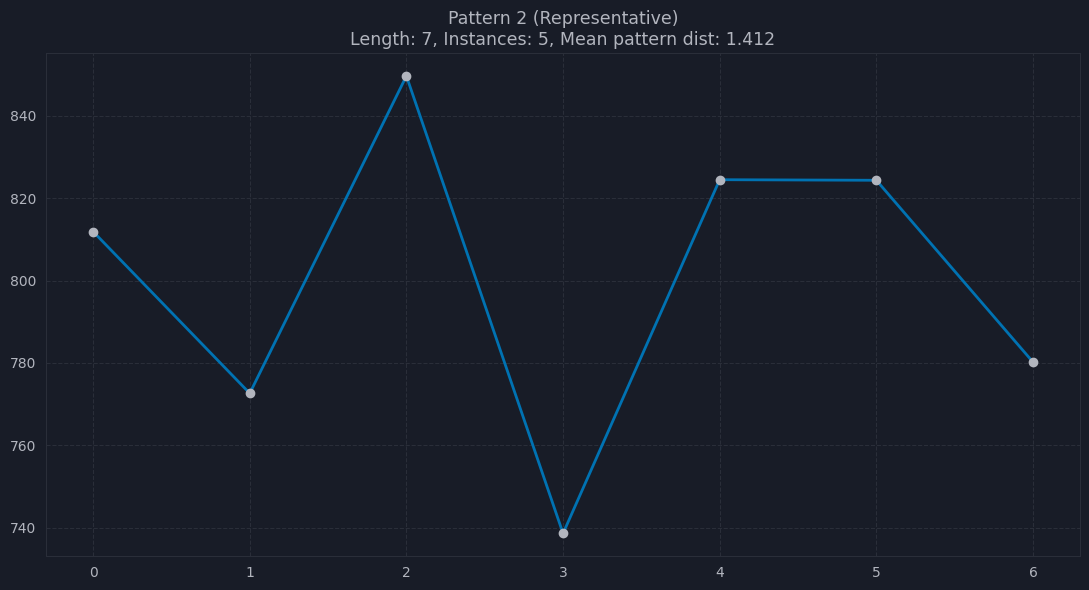

In [86]:
# Appearance of the pattern (Pepresentative instance)
pattern.show_shape()

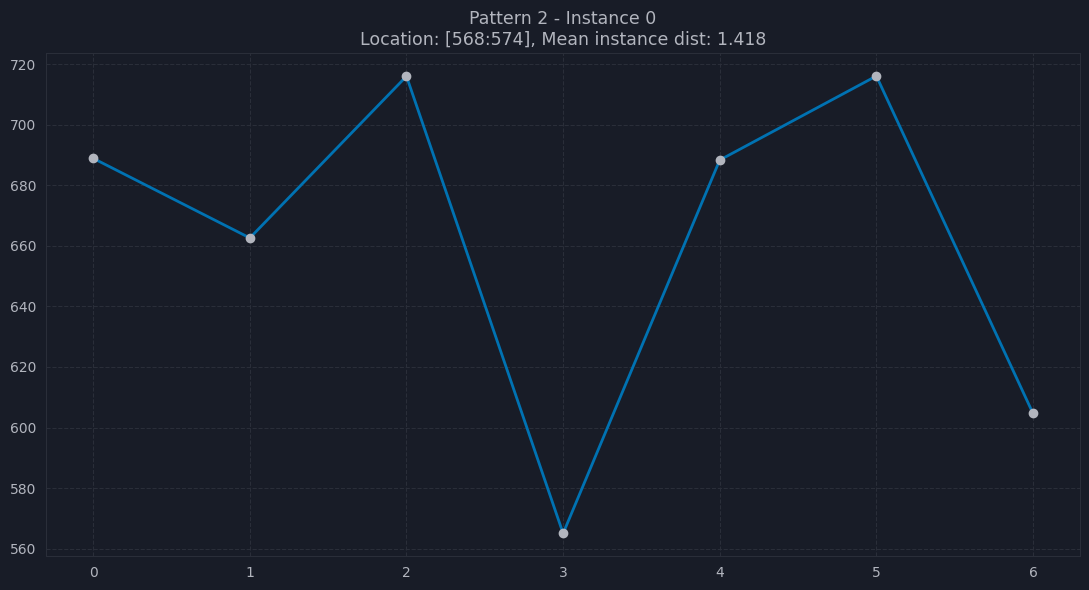

In [87]:
# Instance 0 of the pattern
pattern.show_instance(0)

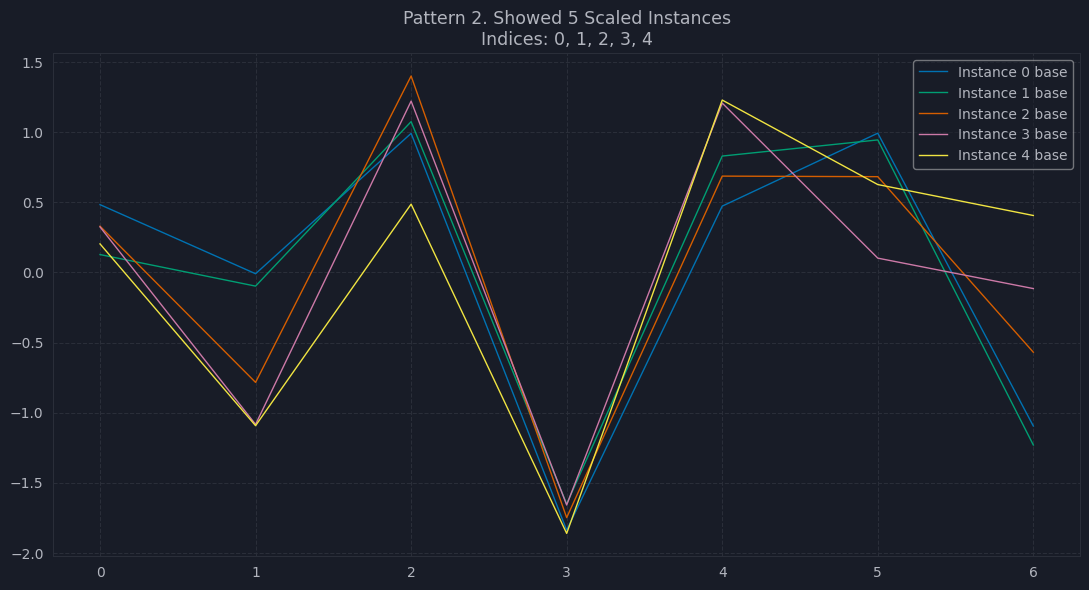

In [88]:
# First 10 instances
# only 5 available
pattern.show_instances(n_first=10)

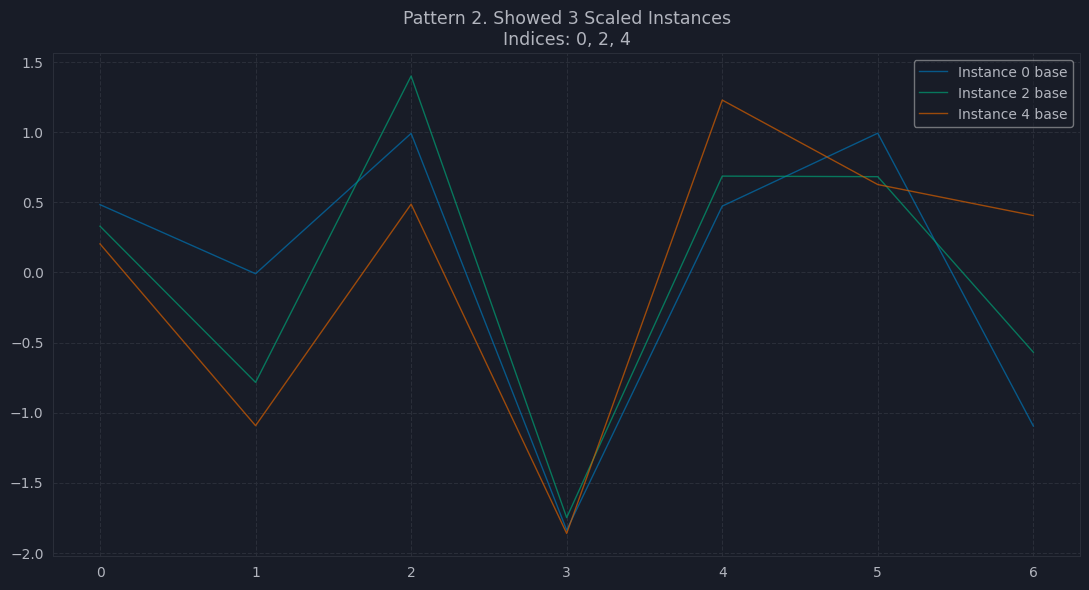

In [89]:
# Specific instances
pattern.show_instances(indices=[0, 2, 4], alpha=0.7)

In [90]:
# Instances of the pattern in time series
# Use the mouse wheel to zoom
pattern.show()

#### Pattern extend (base, similarity, dtw)

In [91]:
# Copy pattern Before extend
import copy
pattern_copy = copy.deepcopy(pattern)
pattern

Pattern(id=2, length=7, instances=5, types=[base=5], mean_dist=1.412)

In [92]:
# After extend
# instances now 51 was 5 (now 5 base and 46 similarity)
# Note that min_distance increased, which means that
# the patterns became less similar to each other
pattern.extend_instances(tolerance=0.1)
pattern

Pattern(id=2, length=7, instances=51, types=[base=5, similarity=46], mean_dist=2.363)

In [93]:
pattern.show()

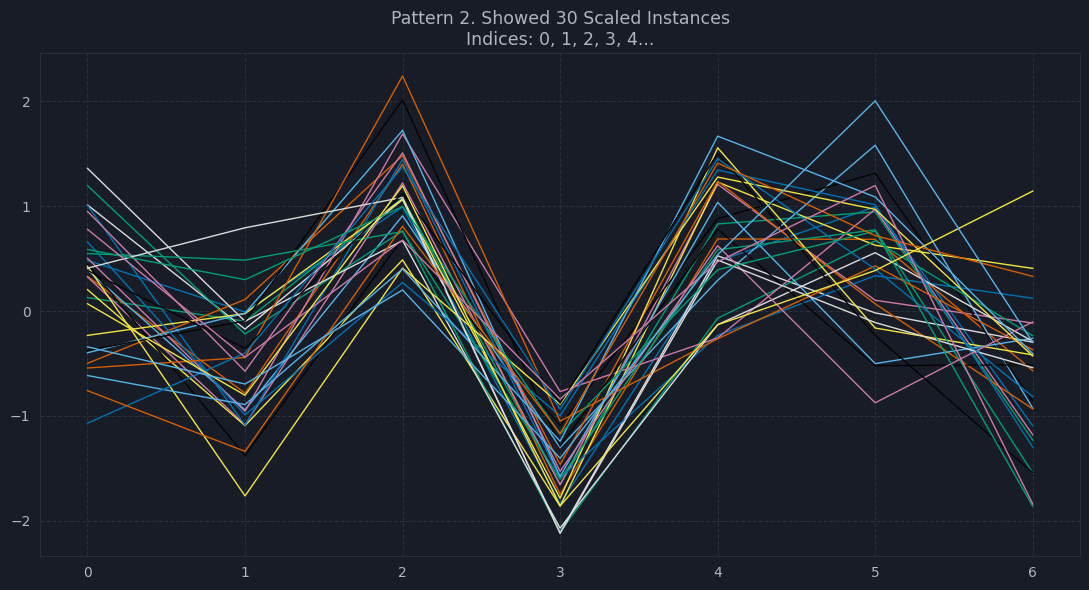

In [94]:
# now 51 available
pattern.show_instances(n_first=30)

In [95]:
# let's extend the instances further
# instances=98, mean_dist=2.919
pattern.extend_instances(tolerance=0.1)
pattern

Pattern(id=2, length=7, instances=98, types=[base=5, similarity=93], mean_dist=2.919)

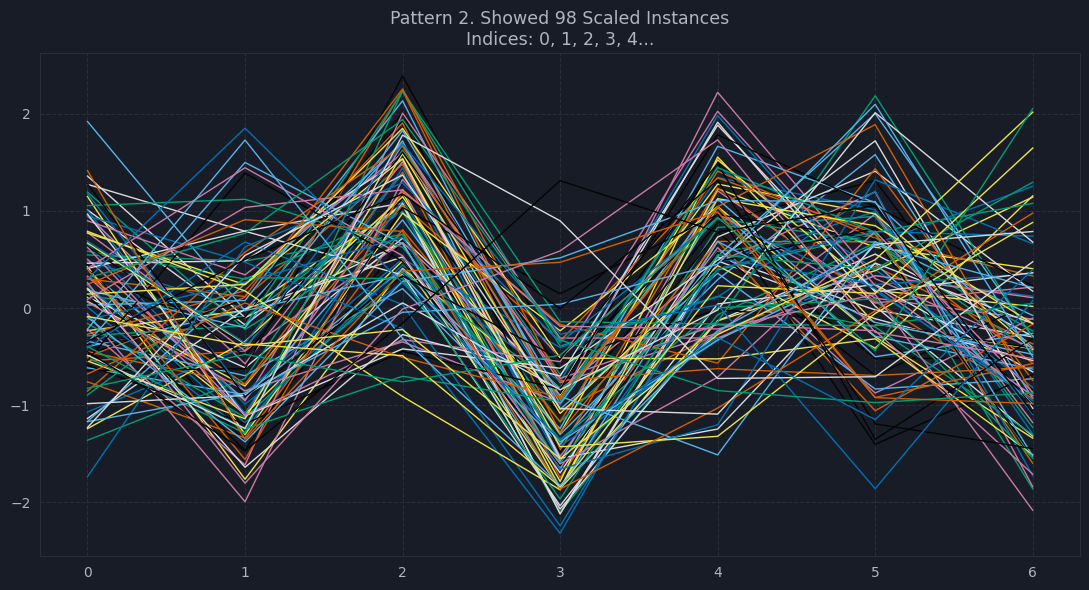

In [96]:
# Note the double expansion with tollerance 0.1 gave
# not very similar patterns to the representative, the average distance increased to 2.919
pattern.show_instances(n_first=98)

In [97]:
# Back to the copy
pattern_copy

Pattern(id=2, length=7, instances=5, types=[base=5], mean_dist=1.412)

In [98]:
# Take into account previous conclusions and expand much less (minus 0.3)
# mean_dist increased less than when tolerance was 0.1
# 4 instances added
pattern_copy.extend_instances(tolerance=-0.3)

Pattern(id=2, length=7, instances=9, types=[base=5, similarity=4], mean_dist=1.603)

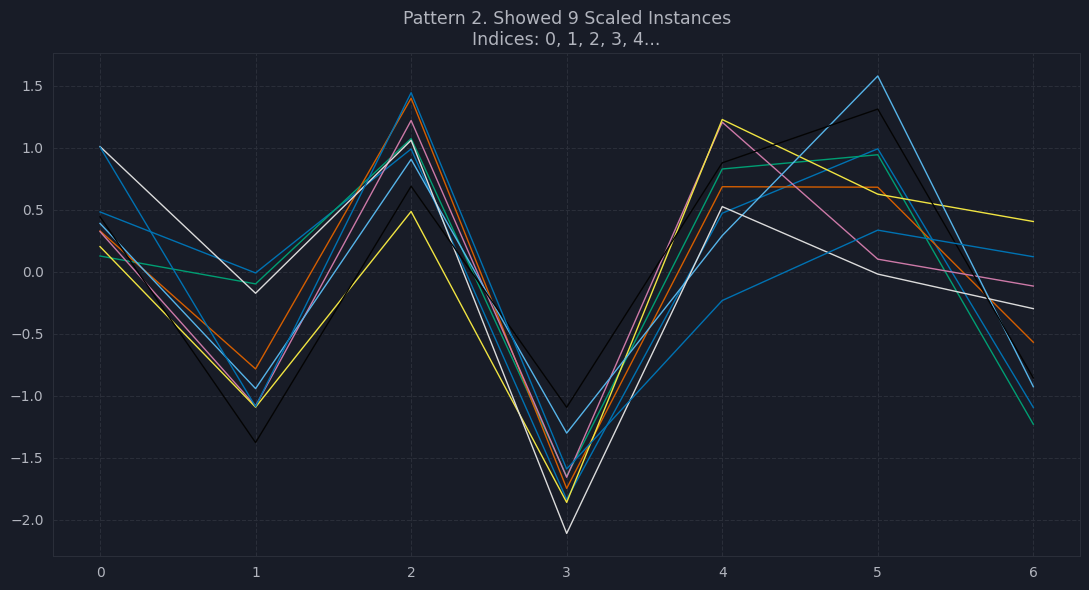

In [99]:
pattern_copy.show_instances(n_first=10)

In [100]:
# extend with dtw patterns additionaly
# 48 dtw instances added
# mean_dist has not changed, as it is calculated only based on base and similarity
pattern_copy.extend_dtw_instances(tolerance=-0.3)

Pattern(id=2, length=7, instances=57, types=[base=5, similarity=4, dtw=48], mean_dist=1.603)

In [101]:
# dtw instance has its own metrics specified in metadata
pattern_copy.instances[-1]

Instance(start_idx=715, end_idx=724, instance_type='dtw', distance_to_others=None, metadata={'alignment_distance': 0.263, 'pattern_distance': 1.58, 'scaled_pattern_distance': 1.585, 'dtw_path': '<11 points>', 'template_instance_idx': 2})

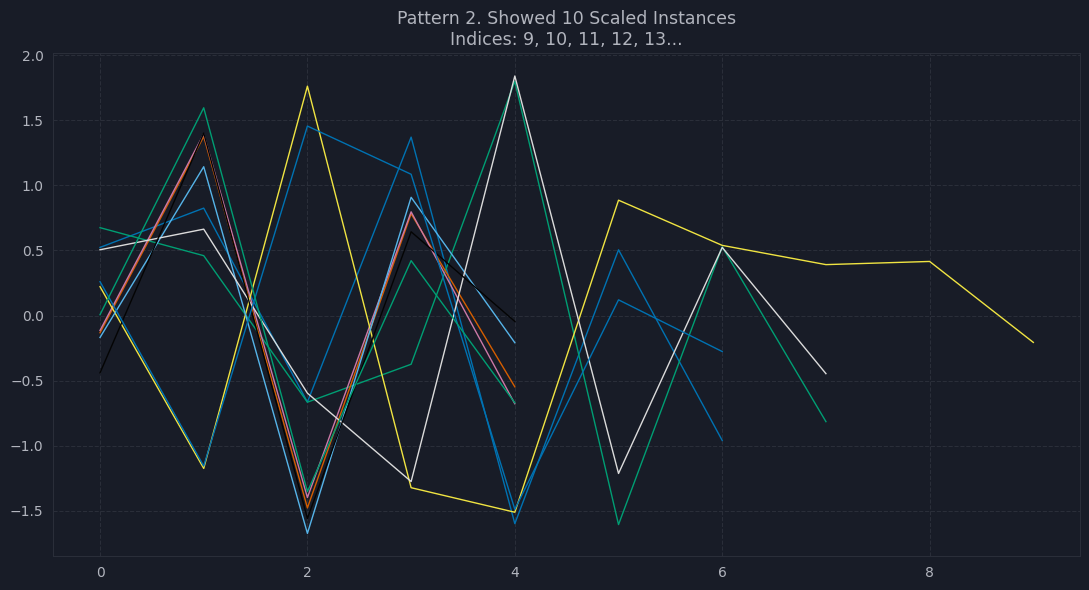

In [102]:
# we can visualize by type
pattern_copy.show_instances(n_first=10, instance_types="dtw")

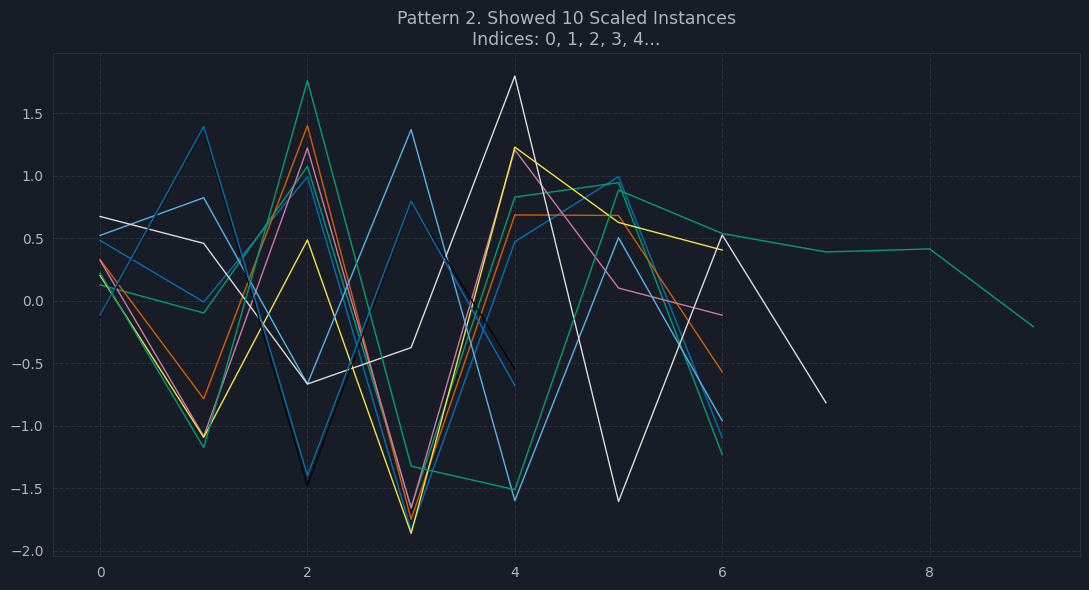

In [103]:
# we can visualize including several types
pattern_copy.show_instances(n_first=10, instance_types=["base", "dtw"])

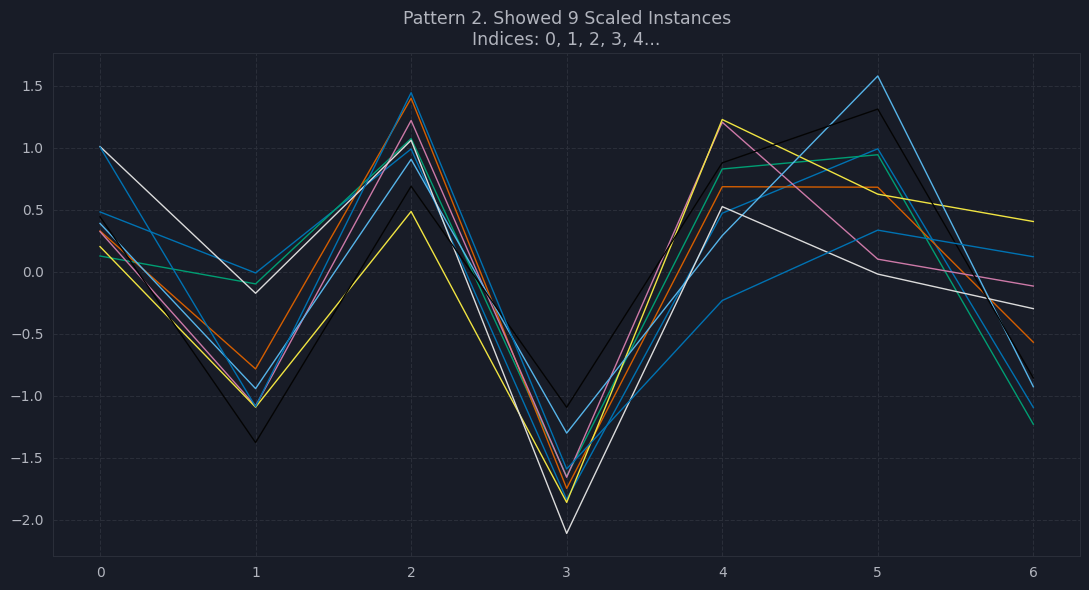

In [104]:
# we can visualize including several types
pattern_copy.show_instances(n_first=10, instance_types=["base", "similarity"])

In [105]:
# Basic tips:
#   use the mouse wheel to zoom in/out on instances
#   click on the line in the legend to hide/show a group of instances
#   hover over an instance to see details, and highlight it
#   hold down the left mouse button on the graph and move the content in different directions
#   click the reset icon in the menu on the right to return to the initial state
pattern_copy.show()

In [107]:
# note that unlike extend_instances(), extend_dtw_instances is immutable because it does not change mean_dist
# which means that you can click it several times and nothing will change
pattern_copy.extend_dtw_instances(tolerance=0.1)

Pattern(id=2, length=7, instances=111, types=[base=5, similarity=4, dtw=102], mean_dist=1.603)

In [109]:
# DTW overlaps allowed for different time scales (<50% or >200% length difference)
# Larger overlapping instances: α=0.3, smaller: α=0.9 (visibility priority)
# Hover any instance → full opacity + highlight color
pattern_copy.show()

#### Pattern utils

In [ ]:
pattern.get_type_counts()

{'base': 5, 'similarity': 93}

In [ ]:
pattern_copy.get_type_counts()

{'base': 5, 'similarity': 4, 'dtw': 48}

In [ ]:
pattern_copy.get_instances_by_type("base")[:3]

[Instance(start_idx=568, end_idx=574, instance_type='base', distance_to_others=[None, 0.569, 1.103, 1.886, 2.113, 1.257, 1.431, 1.686, 2.028], metadata=None),
 Instance(start_idx=661, end_idx=667, instance_type='base', distance_to_others=[0.569, None, 1.074, 1.769, 2.079, 1.31, 1.699, 1.573, 2.284], metadata=None),
 Instance(start_idx=685, end_idx=691, instance_type='base', distance_to_others=[1.103, 1.074, None, 0.972, 1.485, 1.249, 1.294, 1.347, 1.42], metadata=None)]

In [ ]:
pattern_copy.get_instances_by_type("dtw")[:3]

[Instance(start_idx=523, end_idx=529, instance_type='dtw', distance_to_others=None, metadata={'alignment_distance': 0.124, 'pattern_distance': 0.733, 'scaled_pattern_distance': 0.772, 'dtw_path': '<8 points>', 'template_instance_idx': 2}),
 Instance(start_idx=298, end_idx=305, instance_type='dtw', distance_to_others=None, metadata={'alignment_distance': 0.14, 'pattern_distance': 0.778, 'scaled_pattern_distance': 0.744, 'dtw_path': '<9 points>', 'template_instance_idx': 2}),
 Instance(start_idx=831, end_idx=835, instance_type='dtw', distance_to_others=None, metadata={'alignment_distance': 0.135, 'pattern_distance': 0.855, 'scaled_pattern_distance': 0.812, 'dtw_path': '<7 points>', 'template_instance_idx': 2})]